# Age Task

## Imports and Random seed

In [1]:
from contextlib import contextmanager
from IPython.display import display
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from tqdm import tqdm
from typing import Optional, Union, List, Tuple
import seaborn as sns

def set_seed(seed: Optional[int]):
    """
    Set the random seed for reproducibility.

    Args:
        seed (Optional[int]): The seed value to set. If None, no action is taken.
    """
    if seed is None:
        return
    else:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
@contextmanager
def timer(name: str) -> None:
    """
    Context manager to measure execution time of code blocks.
    """
    start_time = time.time()
    yield
    elapsed_seconds = time.time() - start_time

    # Format time as hh:mm:ss
    hours, remainder = divmod(int(elapsed_seconds), 3600)
    minutes, seconds = divmod(remainder, 60)
    milliseconds = int((elapsed_seconds - int(elapsed_seconds)) * 1000)

    if hours > 0:
        time_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}.{milliseconds:03d}"
    else:
        time_str = f"{minutes:02d}:{seconds:02d}.{milliseconds:03d}"

    print(f"{name} completed in {time_str}")

## 1. Prepare Dataset

Download via kagglehub

In [3]:
base_path = os.getcwd()
data_path = os.path.join(base_path, "data")
os.environ["KAGGLEHUB_CACHE"] = data_path
path = kagglehub.dataset_download(handle="jangedoo/utkface-new")
path = os.path.join(path, "UTKFace")

print("Path to dataset files:", path)

Path to dataset files: p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace


Load the Dataset from local drive `data` to pandas dataframe.

In [4]:
data = []

for file in os.listdir(path):
    try:
        age, gender, race, _ = file.split("_")
    except ValueError:
        age, gender, race = file.split("_")
    img_path = os.path.join(path, file)
    data.append([img_path, int(age)])

df = pd.DataFrame(data, columns=["image_path", "age"])

Display the head of the created DataFrame

In [5]:
pd.set_option("display.max_colwidth", None)
df.head(n=30)

,image_path,age
0,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100
1,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100
2,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100
3,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100
4,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100
5,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_0_20170112215032192.jpg.chip.jpg,100
6,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_0_20170117195420803.jpg.chip.jpg,100
7,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_0_20170119212053665.jpg.chip.jpg,100
8,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_2_20170105174847679.jpg.chip.jpg,100
9,p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_2_20170112213615815.jpg.chip.jpg,100


## 2. Inspect and normalize the Dataset

Let's start with some insights from the distribution.

                age
count  23708.000000
mean      33.303484
std       19.886112
min        1.000000
25%       23.000000
50%       29.000000
75%       45.000000
max      116.000000


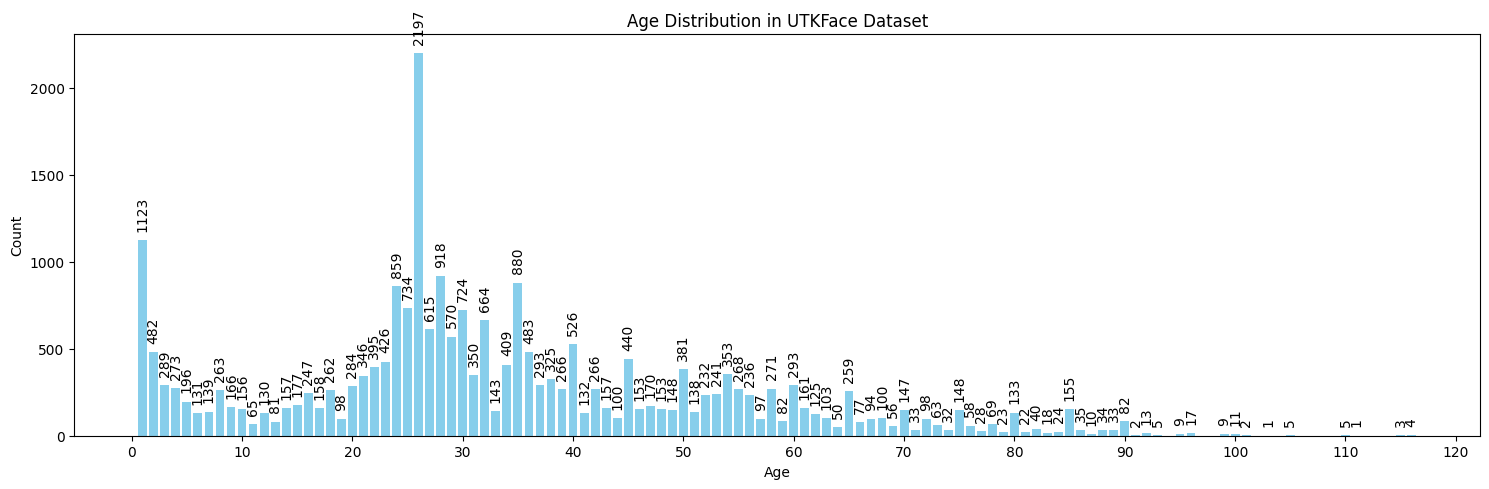

In [6]:
print(df.describe())
# print(df['age'].value_counts().sort_index())  # Check age distribution

unique_ages, age_counts = np.unique(df['age'], return_counts=True)

plt.figure(figsize=(15, 5))
bars = plt.bar(unique_ages, age_counts, color='skyblue') # range(len(unique_ages))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution in UTKFace Dataset')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), va='bottom', ha='center', rotation=90)

plt.xticks(np.arange(0, 120.1, 10))
plt.tight_layout()
plt.show()


Now I split the data with StratifiedKFold

In [7]:
# # bins = np.linspace(df['age'].min(), df['age'].max(), 12)

# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     df['image_path'], df['age'], test_size=0.2, random_state=42
# )

# skf = KFold(n_splits=5, shuffle=True, random_state=42)
# folds = skf.split(X_train_val, y_train_val)

# # Visualize all fold distributions
# plt.figure(figsize=(15, 25))

# for fold, (train_index, val_index) in enumerate(folds):
#     train_df = df.iloc[train_index]
#     val_df = df.iloc[val_index]
    
#     # unique_ages_train, age_counts_train = np.unique(train_df['age'], return_counts=True)
#     # unique_ages_val, age_counts_val = np.unique(val_df['age'], return_counts=True)
#     train_dist = train_df['age'].value_counts(normalize=True).sort_index()
#     val_dist = val_df['age'].value_counts(normalize=True).sort_index()

#     # Plot distributions
#     plt.subplot(5, 1, fold + 1)
#     # x = np.arange(len(age_counts))
#     width = 0.35

#     plt.bar(train_dist.index - width/2, train_dist, width, label='Train', color='skyblue')
#     plt.bar(val_dist.index + width/2, val_dist, width, label='Validation', color='salmon')
    
#     plt.xlabel('Age')
#     plt.ylabel('Proportion')
#     plt.title(f'Age Distribution in Fold {fold + 1}')
#     plt.legend()
#     plt.xticks(np.arange(0, 120.1, 10))
#     plt.tight_layout()

# plt.tight_layout()
# plt.show()

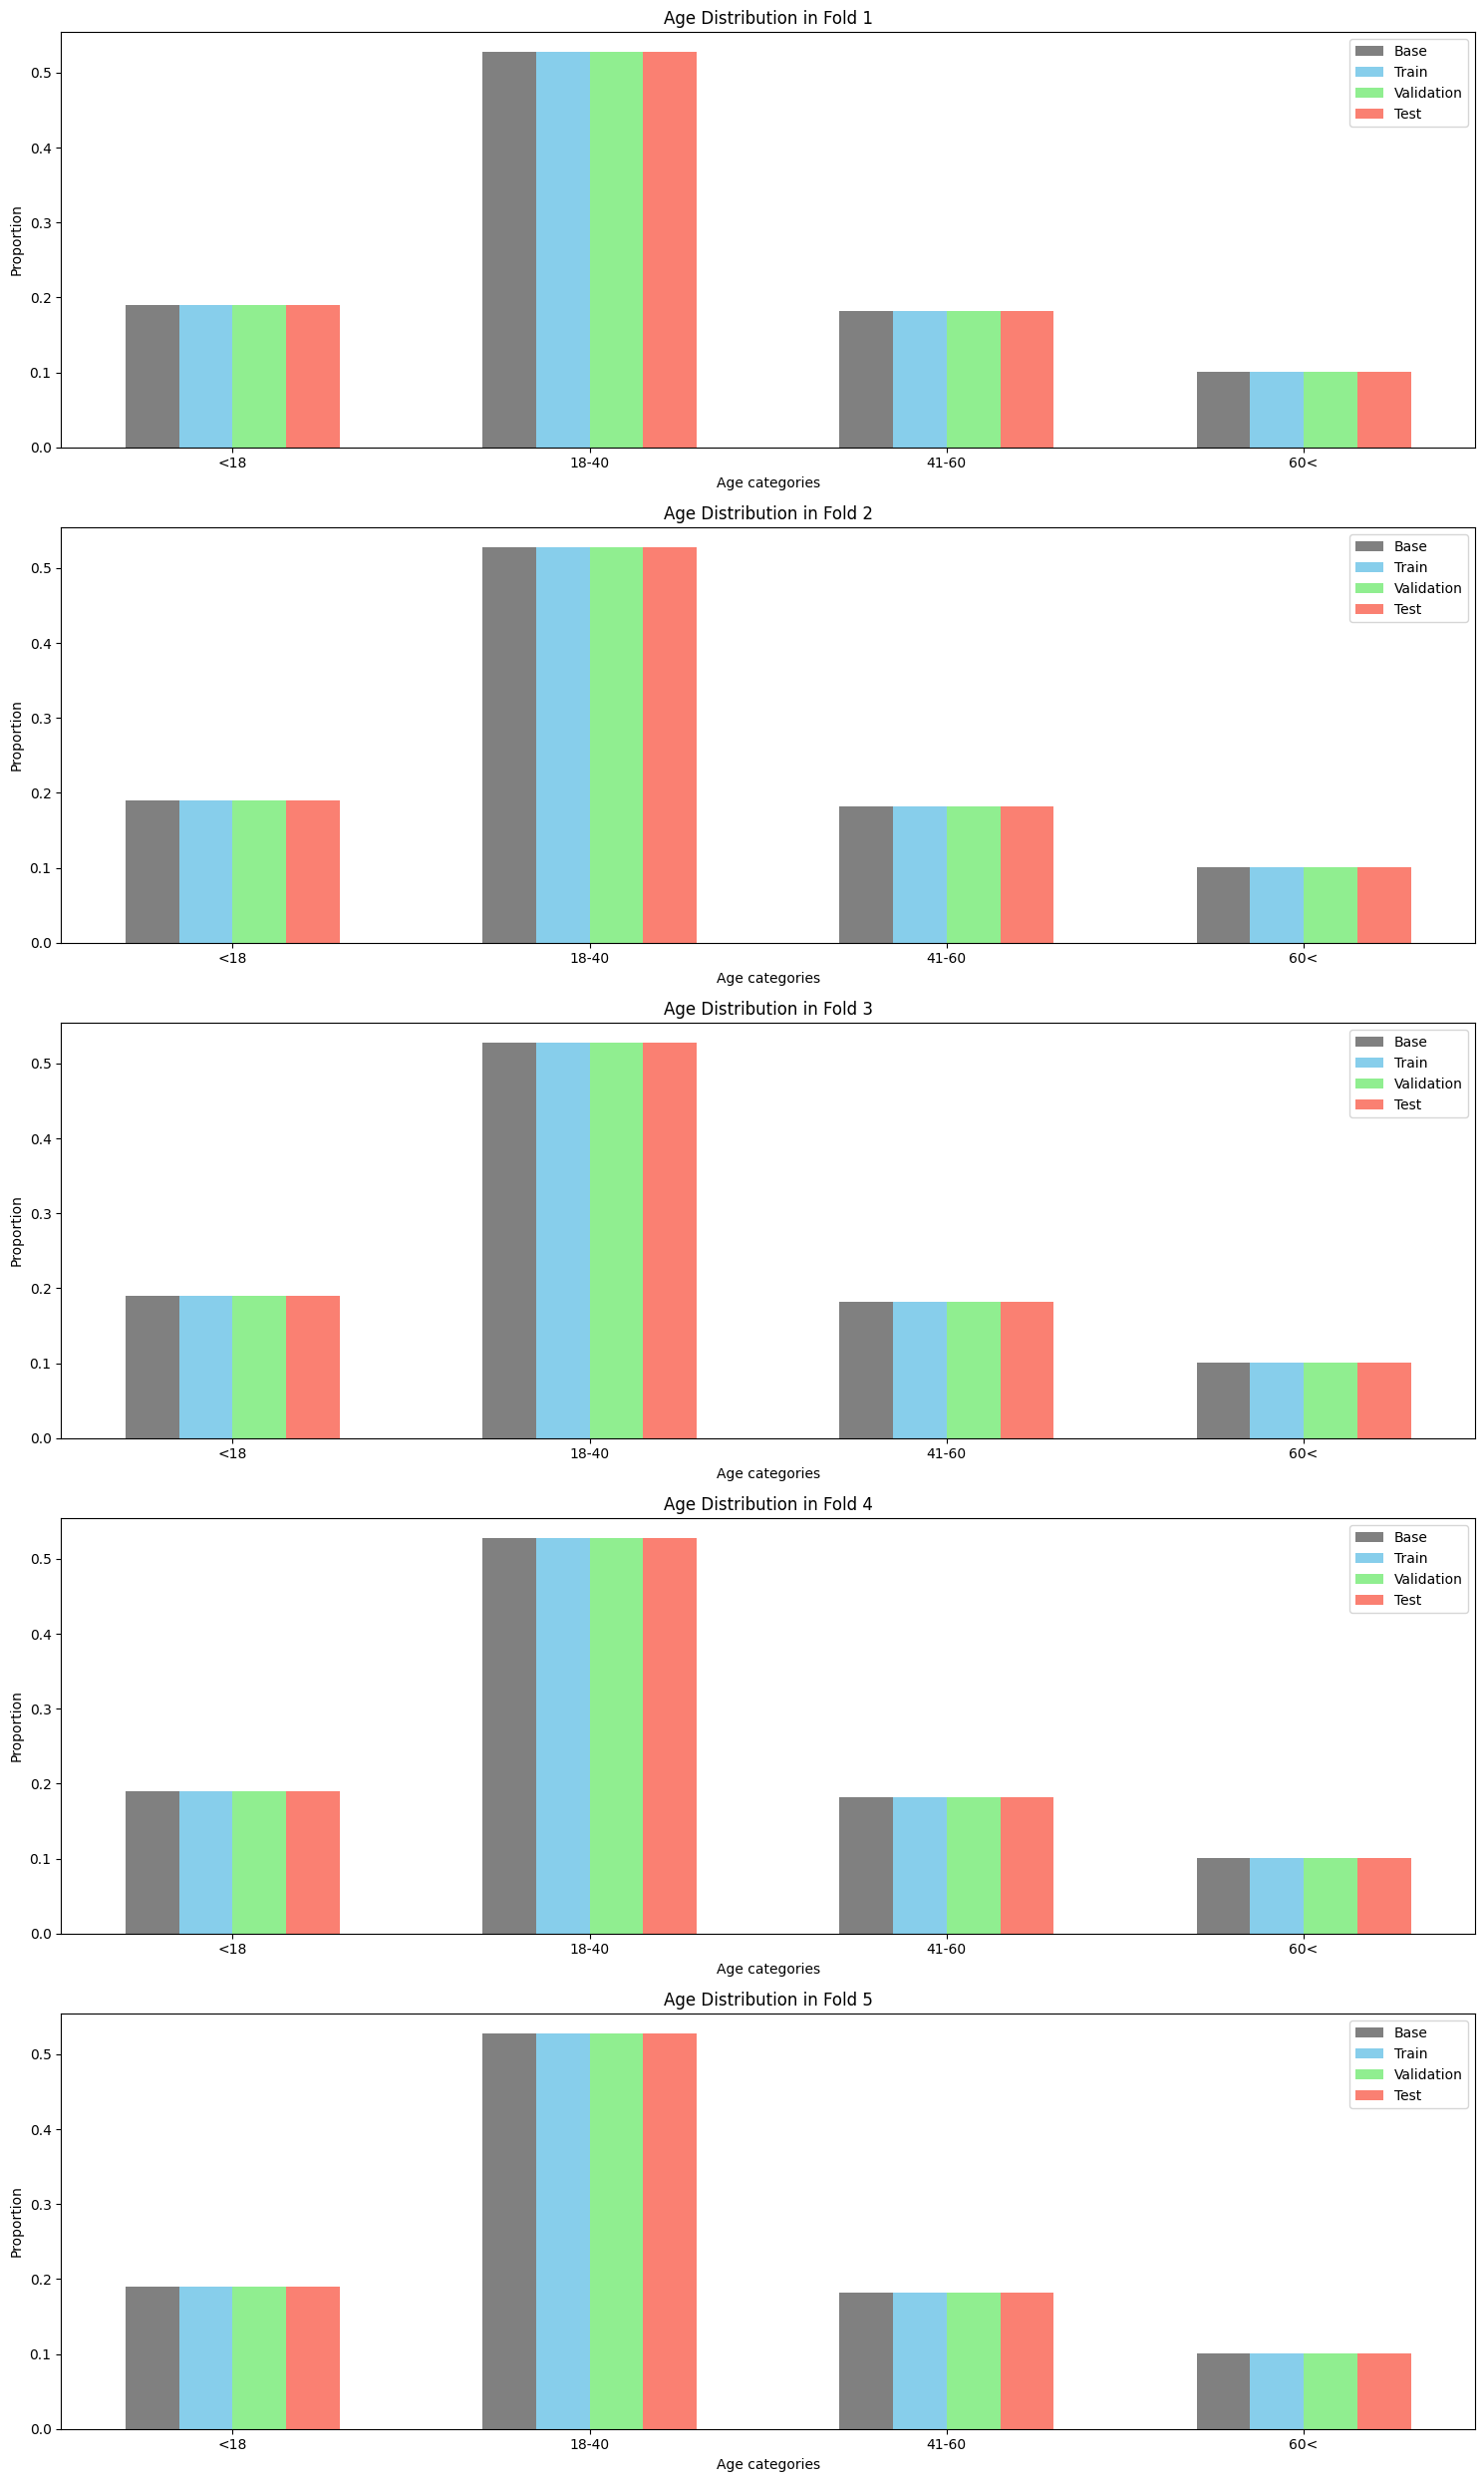

In [8]:
# Define age categories
bins = [0, 18, 40, 60, np.inf]
labels = ["<18", "18-40", "41-60", "60<"]
df['age_category'] = pd.cut(df['age'], bins=bins, labels=labels)

# Split into Train+Validation and Test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['image_path'], df['age_category'], test_size=0.2, random_state=42, stratify=df['age_category']
)
test_df = df.loc[df['image_path'].isin(X_test)]

# Prepare data for StratifiedKFold
train_val_df = df.loc[df['image_path'].isin(X_train_val)]
X = train_val_df['image_path']
y = train_val_df['age_category']

# Further split Train+Validation into Train and Validation sets with StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = skf.split(X, y)

# Prepare to visualize all fold distributions
plt.figure(figsize=(15, 25))

for fold, (train_index, val_index) in enumerate(folds):
    train_df = train_val_df.iloc[train_index]
    val_df = train_val_df.iloc[val_index]
    
    # Calculate proportions for each age category
    base_dist = df['age_category'].value_counts(normalize=True).sort_index()
    test_dist = test_df['age_category'].value_counts(normalize=True).sort_index()
    train_dist = train_df['age_category'].value_counts(normalize=True).sort_index()
    val_dist = val_df['age_category'].value_counts(normalize=True).sort_index()

    # Plot distributions
    plt.subplot(5, 1, fold + 1)
    width = 0.15
    x = np.arange(len(train_dist))

    plt.bar(x - 1.5 * width, train_dist, width, label='Base', color='grey')
    plt.bar(x - width/2, val_dist, width, label='Train', color='skyblue')
    plt.bar(x + width/2, test_dist, width, label='Validation', color='lightgreen')
    plt.bar(x + 1.5 * width, train_dist, width, label='Test', color='salmon')
    
    plt.xlabel('Age categories')
    plt.ylabel('Proportion')
    plt.title(f'Age Distribution in Fold {fold + 1}')
    plt.legend()
    plt.xticks(x, train_dist.index.astype(str))
    plt.tight_layout()

plt.tight_layout()
plt.show()

Add class weights because of imbalance in the age categories.

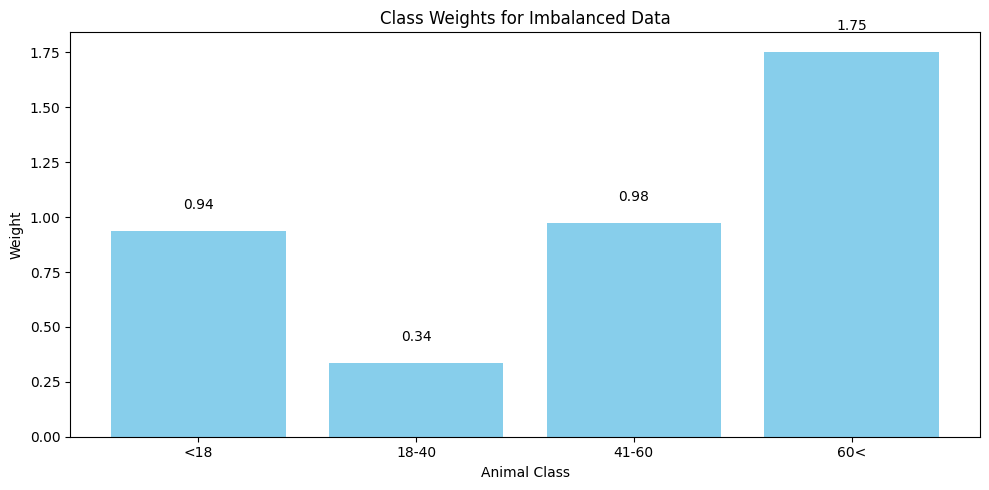

Class weights tensor: tensor([0.9351, 0.3361, 0.9751, 1.7536], device='cuda:0')


In [9]:
# Get the unique classes
classes = np.unique(df['age_category'])
num_classes = len(classes)

# # Compute class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=classes,
#     y=df['age_category']
# )

# Calculate class weights inversely proportional to class frequencies
class_counts = df['age_category'].value_counts().sort_index().values
class_weights = 1. / class_counts
class_weights = class_weights / np.sum(class_weights) * num_classes  # Normalize

# Display weights
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(labels)), class_weights, color='skyblue')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Animal Class')
plt.ylabel('Weight')
plt.title('Class Weights for Imbalanced Data')

# Add weight values above bars
for i, (weight, bar) in enumerate(zip(class_weights, bars)):
    plt.text(i, weight + 0.1, f'{weight:.2f}', ha='center')

plt.tight_layout()
plt.show()

# Convert class weights to a pytorch tensor
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print("Class weights tensor:", class_weights_tensor)

Create Dataset and Dataloader for this splits.

In [10]:
class AgeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Custom dataset for loading images and labels.

        Args:
            image_paths (pd.Series): Paths to the images.
            labels (pd.Series): Corresponding labels (age categories).
            transform (callable, optional): Transformations to apply to the images.
        """
        self.image_paths = image_paths.values
        self.labels = labels.values
        self.transform = transform

        # Create a mapping from age categories to numeric labels
        self.label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB format

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get label
        label = self.labels[idx]
        label = self.label_to_index[label]
        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor

        return image, label

transform = transforms.Compose([
    transforms.Resize((200, 200)),  # Resize images to 224x224
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize(          # Normalize using ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## 3. Create Network for Classification

In [11]:
def create_model(num_classes: int):
    """
    Create a ResNet model with a modified final layer to match the number of classes.

    Args:
        num_classes (int): The number of output classes for the model.

    Returns:
        torch.nn.Module: The modified ResNet model.
    """
    # Load a pre-trained ResNet model
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Modify the final layer to match the number of classes
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

    return resnet

# resnet = create_model(num_classes)

# # Display the model architecture
# print(resnet)


Create train loop function

In [12]:
# Create function for training
def train_model_folds(folds, train_val_df, transform, loss_fn, num_epochs, checkpoint_path, patience, device):
    # Placeholder for fold results
    fold_results = []

    for fold, (train_index, val_index) in enumerate(folds):

        # Split data into train and validation sets
        train_df = train_val_df.iloc[train_index]
        val_df = train_val_df.iloc[val_index]

        X_train = train_df['image_path']
        y_train = train_df['age_category']
        X_val = val_df['image_path']
        y_val = val_df['age_category']

        # Create datasets
        train_dataset = AgeDataset(X_train, y_train, transform=transform)
        val_dataset = AgeDataset(X_val, y_val, transform=transform)
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
        
        # Init model
        model = create_model(num_classes)

        # Define optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        # Define scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        with timer("Training process"):
            # Train the model
            fold_no = fold + 1
            print(f"Training on fold {fold_no}")
            history = train_model(fold_no, model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device, checkpoint_path, patience)

        # Store results for this fold
        fold_result = {
            'fold': fold_no,
            'val_loss': history['val_loss'],
            'val_accuracy': history['val_accuracy'],
        }
        fold_results.append(fold_result)

        torch.save(model.state_dict(), os.path.join(checkpoint_path, f"model_fold_{fold + 1}.pth"))
        np.save(os.path.join(checkpoint_path, f"history_fold_{fold + 1}.npy"), history)
            
def train_model(fold_no, model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device, checkpoint_path, patience):
    # Init history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    if checkpoint_path is not None:
        os.makedirs(checkpoint_path, exist_ok=True)
        best_value_checkpoint = float('inf')

    # Move model to device
    model.train()
    model.to(device)

    # Early stopping parameters
    if patience is not None:
        best_value_early_stopping = float('inf')
        no_improvement_count = 0

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Stats
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            train_bar.set_postfix({'loss':loss.item(), 'acc':100 * correct / total})

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total

        val_loss, val_accuracy = evaluate_model(model, val_loader, loss_fn, device)

        # Update scheduler
        if scheduler is not None:
            scheduler.step()

        # Store results in history
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, "
              f"  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        # Save model checkpoint if validation loss improves
        if checkpoint_path is not None:
            if history['val_loss'][-1] < best_value_checkpoint:
                best_value_checkpoint = history['val_loss'][-1]
                torch.save(model.state_dict(), os.path.join(checkpoint_path, f"best_model_fold_{fold_no}.pth"))
                print(f"Model saved for fold {fold_no} at epoch {epoch + 1} with val_loss {best_value_checkpoint:.4f} and val_accuracy {val_accuracy:.2f}%")

        min_delta = 0.001
        # Early stopping
        if patience is not None:
            if history['val_loss'][-1] < (best_value_early_stopping - min_delta):
                best_value_early_stopping = history['val_loss'][-1]
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1} for fold {fold_no}")
                    break
    
    return history

def evaluate_model(model, val_loader, loss_fn, device):
    """
    Evaluate the model on the validation set.

    Args:
        model (torch.nn.Module): The trained model.
        val_loader (DataLoader): DataLoader for the validation set.
        loss_fn (torch.nn.Module): Loss function to use for evaluation.
        device (torch.device): Device to run the evaluation on.

    Returns:
        float: Validation loss.
        float: Validation accuracy.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        # Use tqdm for progress bar
        val_bar = tqdm(val_loader, desc="Validation")
        for images, labels in val_bar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            val_bar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy

Start training

In [13]:
num_epochs = 20

# Define loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Result dictionary to store resulting model
results_folder = 'age_model/'
os.makedirs(results_folder, exist_ok=True)

# Create new generator object for folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = skf.split(X, y)

train_model_folds(
    folds, train_val_df, transform, loss_fn, num_epochs,
    checkpoint_path=results_folder, patience=10, device=device
)

Training on fold 1


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.23it/s, loss=0.368, acc=76.3] 


Epoch [1/20],   Train Loss: 0.5040, Train Acc: 73.08%,   Val Loss: 0.6122, Val Acc: 76.25%
Model saved for fold 1 at epoch 1 with val_loss 0.6122 and val_accuracy 76.25%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.95it/s, loss=1.33, acc=55.8] 


Epoch [2/20],   Train Loss: 1.1183, Train Acc: 51.96%,   Val Loss: 1.1602, Val Acc: 55.80%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.30it/s, loss=1.59, acc=55]   


Epoch [3/20],   Train Loss: 1.0117, Train Acc: 54.56%,   Val Loss: 1.1183, Val Acc: 55.03%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.98it/s, loss=0.522, acc=52.1]


Epoch [4/20],   Train Loss: 0.9135, Train Acc: 58.69%,   Val Loss: 1.1053, Val Acc: 52.13%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.79it/s, loss=0.606, acc=68.7]


Epoch [5/20],   Train Loss: 0.7814, Train Acc: 63.41%,   Val Loss: 0.7849, Val Acc: 68.71%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.15it/s, loss=0.613, acc=71]  


Epoch [6/20],   Train Loss: 0.5761, Train Acc: 70.13%,   Val Loss: 0.6877, Val Acc: 71.01%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.96it/s, loss=0.658, acc=71.8]


Epoch [7/20],   Train Loss: 0.5468, Train Acc: 71.11%,   Val Loss: 0.6465, Val Acc: 71.82%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.16it/s, loss=0.443, acc=71.4]


Epoch [8/20],   Train Loss: 0.5272, Train Acc: 71.65%,   Val Loss: 0.6652, Val Acc: 71.40%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.04it/s, loss=0.453, acc=71.7]


Epoch [9/20],   Train Loss: 0.5121, Train Acc: 72.01%,   Val Loss: 0.6346, Val Acc: 71.72%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.01it/s, loss=0.5, acc=73.2]  


Epoch [10/20],   Train Loss: 0.4968, Train Acc: 72.41%,   Val Loss: 0.6100, Val Acc: 73.17%
Model saved for fold 1 at epoch 10 with val_loss 0.6100 and val_accuracy 73.17%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.25it/s, loss=0.485, acc=72.9]


Epoch [11/20],   Train Loss: 0.4735, Train Acc: 73.41%,   Val Loss: 0.6159, Val Acc: 72.93%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.87it/s, loss=0.478, acc=72.7]


Epoch [12/20],   Train Loss: 0.4703, Train Acc: 73.40%,   Val Loss: 0.6191, Val Acc: 72.75%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.09it/s, loss=0.473, acc=72.8]


Epoch [13/20],   Train Loss: 0.4686, Train Acc: 73.64%,   Val Loss: 0.6166, Val Acc: 72.77%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.62it/s, loss=0.501, acc=73.1]


Epoch [14/20],   Train Loss: 0.4660, Train Acc: 73.58%,   Val Loss: 0.6084, Val Acc: 73.09%
Model saved for fold 1 at epoch 14 with val_loss 0.6084 and val_accuracy 73.09%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.66it/s, loss=0.473, acc=73.1]


Epoch [15/20],   Train Loss: 0.4642, Train Acc: 73.64%,   Val Loss: 0.6121, Val Acc: 73.14%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.97it/s, loss=0.489, acc=73.1]


Epoch [16/20],   Train Loss: 0.4616, Train Acc: 73.71%,   Val Loss: 0.6089, Val Acc: 73.14%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.55it/s, loss=0.488, acc=73.1]


Epoch [17/20],   Train Loss: 0.4608, Train Acc: 73.73%,   Val Loss: 0.6093, Val Acc: 73.14%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.09it/s, loss=0.488, acc=73.2]


Epoch [18/20],   Train Loss: 0.4610, Train Acc: 73.75%,   Val Loss: 0.6097, Val Acc: 73.17%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.19it/s, loss=0.488, acc=73.2]


Epoch [19/20],   Train Loss: 0.4613, Train Acc: 73.78%,   Val Loss: 0.6091, Val Acc: 73.19%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.02it/s, loss=0.482, acc=73.2]


Epoch [20/20],   Train Loss: 0.4607, Train Acc: 73.81%,   Val Loss: 0.6100, Val Acc: 73.22%
Training process completed in 10:44.125
Training on fold 2


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.27it/s, loss=0.18, acc=76.5]  


Epoch [1/20],   Train Loss: 0.4994, Train Acc: 72.88%,   Val Loss: 0.5548, Val Acc: 76.54%
Model saved for fold 2 at epoch 1 with val_loss 0.5548 and val_accuracy 76.54%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.21it/s, loss=1.12, acc=51.5] 


Epoch [2/20],   Train Loss: 1.4305, Train Acc: 50.90%,   Val Loss: 1.2030, Val Acc: 51.54%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.37it/s, loss=1.03, acc=51.4] 


Epoch [3/20],   Train Loss: 1.0233, Train Acc: 54.21%,   Val Loss: 1.2120, Val Acc: 51.44%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.11it/s, loss=1.07, acc=56.5] 


Epoch [4/20],   Train Loss: 0.9765, Train Acc: 55.58%,   Val Loss: 1.0957, Val Acc: 56.53%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.54it/s, loss=0.944, acc=59.6]


Epoch [5/20],   Train Loss: 0.9102, Train Acc: 58.08%,   Val Loss: 0.9819, Val Acc: 59.61%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.12it/s, loss=0.712, acc=63.6]


Epoch [6/20],   Train Loss: 0.7780, Train Acc: 62.82%,   Val Loss: 0.8996, Val Acc: 63.64%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.06it/s, loss=0.742, acc=65.5]


Epoch [7/20],   Train Loss: 0.7085, Train Acc: 65.18%,   Val Loss: 0.8330, Val Acc: 65.52%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.34it/s, loss=0.682, acc=66.8]


Epoch [8/20],   Train Loss: 0.6641, Train Acc: 66.72%,   Val Loss: 0.7946, Val Acc: 66.78%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.99it/s, loss=0.426, acc=66]  


Epoch [9/20],   Train Loss: 0.6421, Train Acc: 67.55%,   Val Loss: 0.8062, Val Acc: 65.96%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.02it/s, loss=0.623, acc=68.4]


Epoch [10/20],   Train Loss: 0.6087, Train Acc: 68.76%,   Val Loss: 0.7627, Val Acc: 68.44%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.13it/s, loss=0.54, acc=69.2] 


Epoch [11/20],   Train Loss: 0.5833, Train Acc: 69.67%,   Val Loss: 0.7289, Val Acc: 69.18%
Early stopping triggered at epoch 11 for fold 2
Training process completed in 05:40.652
Training on fold 3


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.13it/s, loss=0.577, acc=74.8] 


Epoch [1/20],   Train Loss: 0.4949, Train Acc: 73.53%,   Val Loss: 0.6892, Val Acc: 74.82%
Model saved for fold 3 at epoch 1 with val_loss 0.6892 and val_accuracy 74.82%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.08it/s, loss=1.18, acc=50.2] 


Epoch [2/20],   Train Loss: 1.1339, Train Acc: 51.16%,   Val Loss: 1.2117, Val Acc: 50.22%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.98it/s, loss=1.11, acc=56.2] 


Epoch [3/20],   Train Loss: 0.9974, Train Acc: 54.76%,   Val Loss: 1.0756, Val Acc: 56.16%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s, loss=0.966, acc=61.5]


Epoch [4/20],   Train Loss: 0.9004, Train Acc: 58.23%,   Val Loss: 0.9896, Val Acc: 61.46%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.63it/s, loss=0.736, acc=68.4]


Epoch [5/20],   Train Loss: 0.7084, Train Acc: 65.64%,   Val Loss: 0.7637, Val Acc: 68.44%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.89it/s, loss=0.65, acc=70.8] 


Epoch [6/20],   Train Loss: 0.5608, Train Acc: 70.28%,   Val Loss: 0.7071, Val Acc: 70.76%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.88it/s, loss=0.61, acc=70.9] 


Epoch [7/20],   Train Loss: 0.5343, Train Acc: 71.26%,   Val Loss: 0.6709, Val Acc: 70.87%
Model saved for fold 3 at epoch 7 with val_loss 0.6709 and val_accuracy 70.87%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.72it/s, loss=0.483, acc=70.5]


Epoch [8/20],   Train Loss: 0.5089, Train Acc: 72.02%,   Val Loss: 0.7029, Val Acc: 70.52%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.88it/s, loss=0.58, acc=71.3] 


Epoch [9/20],   Train Loss: 0.4951, Train Acc: 72.51%,   Val Loss: 0.6548, Val Acc: 71.32%
Model saved for fold 3 at epoch 9 with val_loss 0.6548 and val_accuracy 71.32%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s, loss=0.576, acc=71.9]


Epoch [10/20],   Train Loss: 0.4765, Train Acc: 72.89%,   Val Loss: 0.6496, Val Acc: 71.92%
Model saved for fold 3 at epoch 10 with val_loss 0.6496 and val_accuracy 71.92%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.70it/s, loss=0.453, acc=71.8]


Epoch [11/20],   Train Loss: 0.4507, Train Acc: 73.92%,   Val Loss: 0.6478, Val Acc: 71.82%
Model saved for fold 3 at epoch 11 with val_loss 0.6478 and val_accuracy 71.82%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s, loss=0.469, acc=71.9]


Epoch [12/20],   Train Loss: 0.4468, Train Acc: 74.13%,   Val Loss: 0.6413, Val Acc: 71.92%
Model saved for fold 3 at epoch 12 with val_loss 0.6413 and val_accuracy 71.92%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.88it/s, loss=0.42, acc=71.9] 


Epoch [13/20],   Train Loss: 0.4435, Train Acc: 74.15%,   Val Loss: 0.6409, Val Acc: 71.87%
Model saved for fold 3 at epoch 13 with val_loss 0.6409 and val_accuracy 71.87%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.72it/s, loss=0.456, acc=72.1]


Epoch [14/20],   Train Loss: 0.4418, Train Acc: 74.28%,   Val Loss: 0.6332, Val Acc: 72.08%
Model saved for fold 3 at epoch 14 with val_loss 0.6332 and val_accuracy 72.08%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.80it/s, loss=0.477, acc=72.1]


Epoch [15/20],   Train Loss: 0.4389, Train Acc: 74.35%,   Val Loss: 0.6284, Val Acc: 72.08%
Model saved for fold 3 at epoch 15 with val_loss 0.6284 and val_accuracy 72.08%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.84it/s, loss=0.444, acc=72.1]


Epoch [16/20],   Train Loss: 0.4362, Train Acc: 74.56%,   Val Loss: 0.6333, Val Acc: 72.08%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.73it/s, loss=0.449, acc=72.1]


Epoch [17/20],   Train Loss: 0.4354, Train Acc: 74.61%,   Val Loss: 0.6312, Val Acc: 72.13%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.93it/s, loss=0.449, acc=72.2]


Epoch [18/20],   Train Loss: 0.4357, Train Acc: 74.58%,   Val Loss: 0.6300, Val Acc: 72.24%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.90it/s, loss=0.458, acc=72.2]


Epoch [19/20],   Train Loss: 0.4354, Train Acc: 74.55%,   Val Loss: 0.6282, Val Acc: 72.24%
Model saved for fold 3 at epoch 19 with val_loss 0.6282 and val_accuracy 72.24%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.02it/s, loss=0.441, acc=72.2]


Epoch [20/20],   Train Loss: 0.4347, Train Acc: 74.60%,   Val Loss: 0.6304, Val Acc: 72.19%
Training process completed in 11:04.234
Training on fold 4


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.75it/s, loss=0.274, acc=75.6] 


Epoch [1/20],   Train Loss: 0.4879, Train Acc: 73.97%,   Val Loss: 0.5977, Val Acc: 75.59%
Model saved for fold 4 at epoch 1 with val_loss 0.5977 and val_accuracy 75.59%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.87it/s, loss=1.53, acc=52.8] 


Epoch [2/20],   Train Loss: 1.2721, Train Acc: 50.79%,   Val Loss: 1.3008, Val Acc: 52.76%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.71it/s, loss=1.33, acc=53.7] 


Epoch [3/20],   Train Loss: 1.0477, Train Acc: 52.56%,   Val Loss: 1.1577, Val Acc: 53.68%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.86it/s, loss=1.22, acc=53.6] 


Epoch [4/20],   Train Loss: 1.0000, Train Acc: 54.23%,   Val Loss: 1.1360, Val Acc: 53.60%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.77it/s, loss=0.944, acc=55]  


Epoch [5/20],   Train Loss: 0.9266, Train Acc: 57.33%,   Val Loss: 1.0662, Val Acc: 55.05%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.89it/s, loss=1.18, acc=62.4] 


Epoch [6/20],   Train Loss: 0.8294, Train Acc: 61.12%,   Val Loss: 0.9477, Val Acc: 62.40%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.67it/s, loss=0.838, acc=62.5]


Epoch [7/20],   Train Loss: 0.7896, Train Acc: 62.98%,   Val Loss: 0.9288, Val Acc: 62.51%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.91it/s, loss=0.859, acc=64.4]


Epoch [8/20],   Train Loss: 0.7631, Train Acc: 63.96%,   Val Loss: 0.8938, Val Acc: 64.41%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.84it/s, loss=0.714, acc=64.1]


Epoch [9/20],   Train Loss: 0.7383, Train Acc: 64.63%,   Val Loss: 0.8907, Val Acc: 64.14%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.87it/s, loss=0.837, acc=65.6]


Epoch [10/20],   Train Loss: 0.7164, Train Acc: 65.48%,   Val Loss: 0.8451, Val Acc: 65.62%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.84it/s, loss=0.786, acc=66]  


Epoch [11/20],   Train Loss: 0.6846, Train Acc: 66.68%,   Val Loss: 0.8454, Val Acc: 66.02%
Early stopping triggered at epoch 11 for fold 4
Training process completed in 06:01.717
Training on fold 5


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.60it/s, loss=0.139, acc=69]  


Epoch [1/20],   Train Loss: 0.4932, Train Acc: 73.66%,   Val Loss: 0.6823, Val Acc: 69.00%
Model saved for fold 5 at epoch 1 with val_loss 0.6823 and val_accuracy 69.00%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.99it/s, loss=1.3, acc=55.4]  


Epoch [2/20],   Train Loss: 1.1759, Train Acc: 49.82%,   Val Loss: 1.1789, Val Acc: 55.39%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.77it/s, loss=1.12, acc=60.9] 


Epoch [3/20],   Train Loss: 1.0165, Train Acc: 54.64%,   Val Loss: 1.0299, Val Acc: 60.88%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.92it/s, loss=0.881, acc=62.7]


Epoch [4/20],   Train Loss: 0.8555, Train Acc: 60.42%,   Val Loss: 0.9259, Val Acc: 62.69%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.90it/s, loss=0.483, acc=68]  


Epoch [5/20],   Train Loss: 0.6584, Train Acc: 67.19%,   Val Loss: 0.7620, Val Acc: 68.02%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.87it/s, loss=0.409, acc=71.4]


Epoch [6/20],   Train Loss: 0.5332, Train Acc: 71.53%,   Val Loss: 0.6440, Val Acc: 71.37%
Model saved for fold 5 at epoch 6 with val_loss 0.6440 and val_accuracy 71.37%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.54it/s, loss=0.437, acc=72.2]


Epoch [7/20],   Train Loss: 0.5087, Train Acc: 72.31%,   Val Loss: 0.6298, Val Acc: 72.16%
Model saved for fold 5 at epoch 7 with val_loss 0.6298 and val_accuracy 72.16%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.77it/s, loss=0.397, acc=72.3]


Epoch [8/20],   Train Loss: 0.4953, Train Acc: 72.71%,   Val Loss: 0.6243, Val Acc: 72.32%
Model saved for fold 5 at epoch 8 with val_loss 0.6243 and val_accuracy 72.32%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.03it/s, loss=0.38, acc=72.5] 


Epoch [9/20],   Train Loss: 0.4837, Train Acc: 73.12%,   Val Loss: 0.6141, Val Acc: 72.53%
Model saved for fold 5 at epoch 9 with val_loss 0.6141 and val_accuracy 72.53%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.78it/s, loss=0.471, acc=73.1]


Epoch [10/20],   Train Loss: 0.4741, Train Acc: 73.47%,   Val Loss: 0.6132, Val Acc: 73.06%
Model saved for fold 5 at epoch 10 with val_loss 0.6132 and val_accuracy 73.06%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s, loss=0.365, acc=73.3]


Epoch [11/20],   Train Loss: 0.4572, Train Acc: 73.97%,   Val Loss: 0.6063, Val Acc: 73.32%
Model saved for fold 5 at epoch 11 with val_loss 0.6063 and val_accuracy 73.32%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.18it/s, loss=0.356, acc=73.3]


Epoch [12/20],   Train Loss: 0.4540, Train Acc: 74.08%,   Val Loss: 0.6018, Val Acc: 73.27%
Model saved for fold 5 at epoch 12 with val_loss 0.6018 and val_accuracy 73.27%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.31it/s, loss=0.35, acc=73.2] 


Epoch [13/20],   Train Loss: 0.4515, Train Acc: 74.16%,   Val Loss: 0.6023, Val Acc: 73.21%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.21it/s, loss=0.367, acc=73.4]


Epoch [14/20],   Train Loss: 0.4500, Train Acc: 74.28%,   Val Loss: 0.6018, Val Acc: 73.40%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.16it/s, loss=0.359, acc=73.4]


Epoch [15/20],   Train Loss: 0.4490, Train Acc: 74.34%,   Val Loss: 0.6017, Val Acc: 73.40%
Model saved for fold 5 at epoch 15 with val_loss 0.6017 and val_accuracy 73.40%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.26it/s, loss=0.362, acc=73.5]


Epoch [16/20],   Train Loss: 0.4468, Train Acc: 74.26%,   Val Loss: 0.5986, Val Acc: 73.45%
Model saved for fold 5 at epoch 16 with val_loss 0.5986 and val_accuracy 73.45%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.25it/s, loss=0.365, acc=73.4]


Epoch [17/20],   Train Loss: 0.4465, Train Acc: 74.30%,   Val Loss: 0.5969, Val Acc: 73.37%
Model saved for fold 5 at epoch 17 with val_loss 0.5969 and val_accuracy 73.37%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.26it/s, loss=0.365, acc=73.6]


Epoch [18/20],   Train Loss: 0.4463, Train Acc: 74.39%,   Val Loss: 0.5971, Val Acc: 73.56%


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.09it/s, loss=0.367, acc=73.4]


Epoch [19/20],   Train Loss: 0.4459, Train Acc: 74.37%,   Val Loss: 0.5974, Val Acc: 73.40%


Validation: 100%|██████████| 30/30 [00:05<00:00,  6.00it/s, loss=0.364, acc=73.5]


Epoch [20/20],   Train Loss: 0.4465, Train Acc: 74.38%,   Val Loss: 0.5969, Val Acc: 73.45%
Model saved for fold 5 at epoch 20 with val_loss 0.5969 and val_accuracy 73.45%
Training process completed in 10:42.500


# 4. Evaluation


Inspect the Test Data

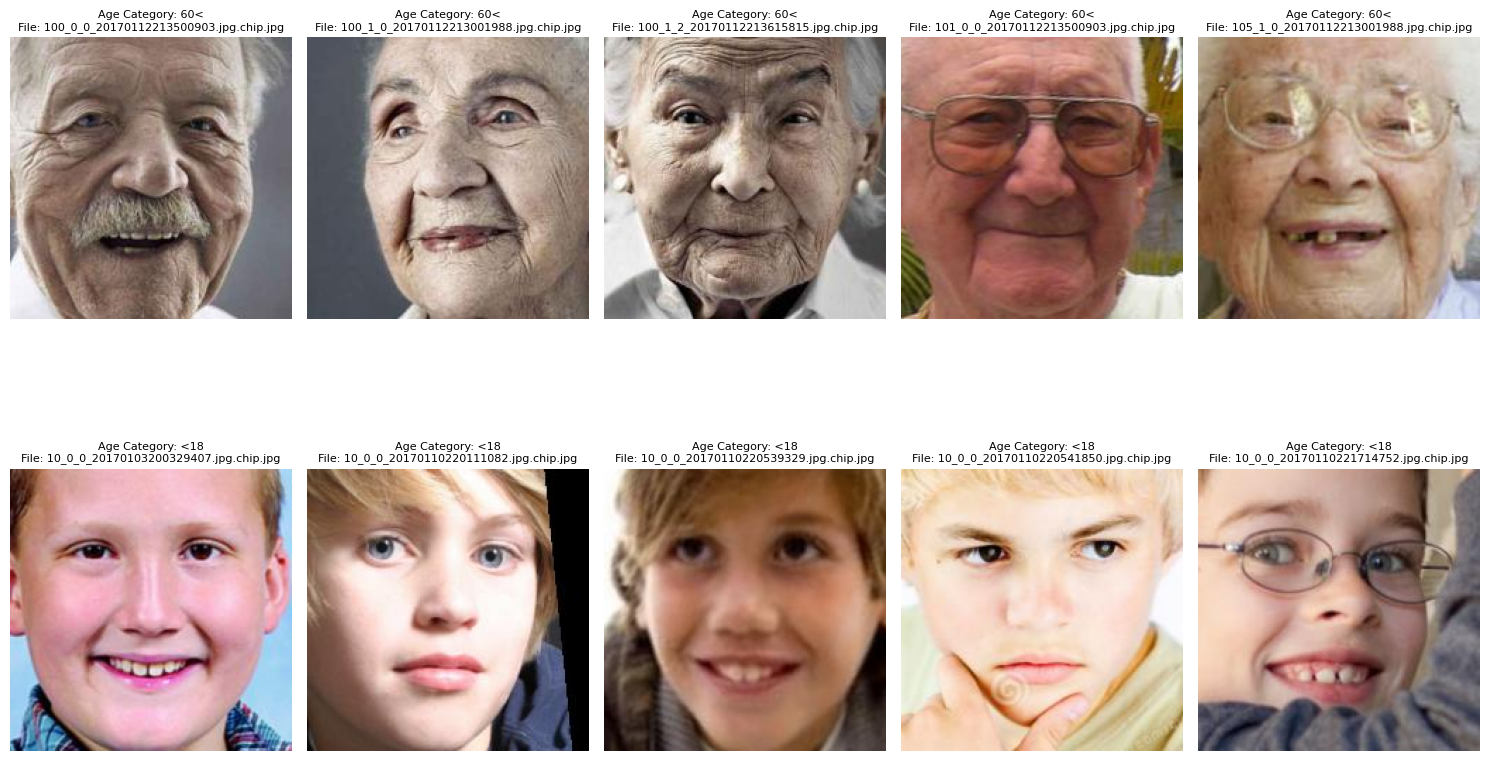

In [14]:
test_dataset = AgeDataset(test_df['image_path'], test_df['age_category'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

# Funktion zum Anzeigen von Bildern mit Labels und Pfaden
def display_images_with_labels_and_filenames(data_loader, dataset, num_images=10):
    # Hole eine Batch von Bildern und Labels
    images, labels = next(iter(data_loader))
    
    # Denormalisierung der Bilder für die Anzeige
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    images = images.permute(0, 2, 3, 1)  # Form ändern zu (Batch, Höhe, Breite, Kanäle)
    images = images * torch.tensor(std).view(1, 1, 1, 3) + torch.tensor(mean).view(1, 1, 1, 3)
    images = images.numpy()
    
    # Hole die Pfade aus dem Dataset
    filenames = [os.path.basename(path) for path in dataset.image_paths[:num_images]]

    # Umkehren der label_to_index-Mapping-Tabelle
    index_to_label = {v: k for k, v in dataset.label_to_index.items()}
    
    # Erstelle die Anzeige
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        # Konvertiere das numerische Label zurück in die age_category
        age_category = index_to_label[labels[i].item()]
        plt.title(f"Age Category: {age_category}\nFile: {filenames[i]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Aufruf der Funktion
display_images_with_labels_and_filenames(test_loader, test_dataset, num_images=10)


Load best model and history per fold

Loading best model from age_model/...
Fold 1 - Best Validation Loss: 0.6084, Best Validation Accuracy: 76.25%


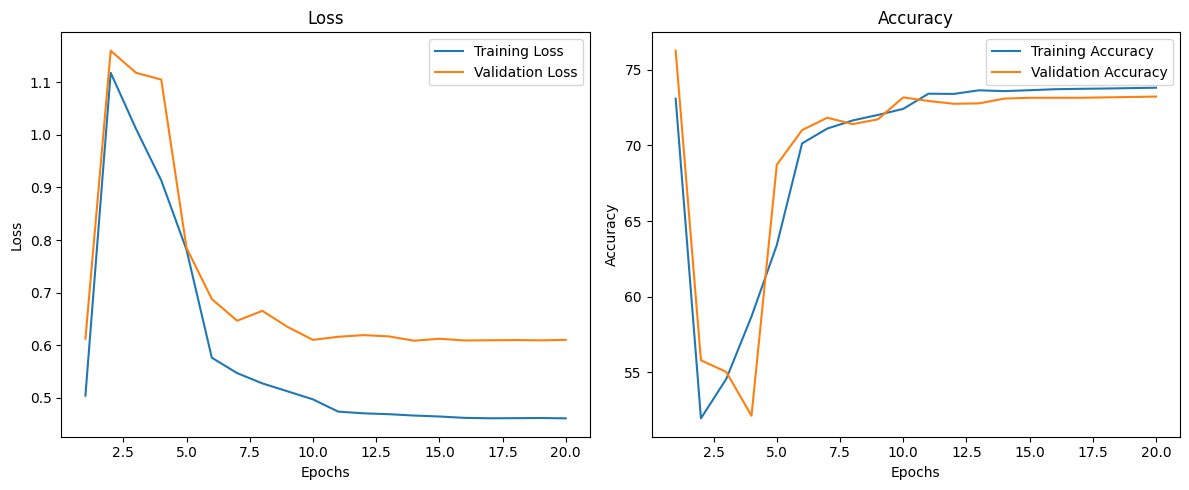

Testing: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


Overall Test Accuracy: 73.05%

Per-class Performance:
class_name  accuracy  avg_confidence  support
     18-40 93.562575        0.821709     2501
     41-60  2.088167        0.373959      862
       60< 77.083333        0.772962      480
       <18 81.868743        0.940541      899
Evaluating process completed in 00:08.295


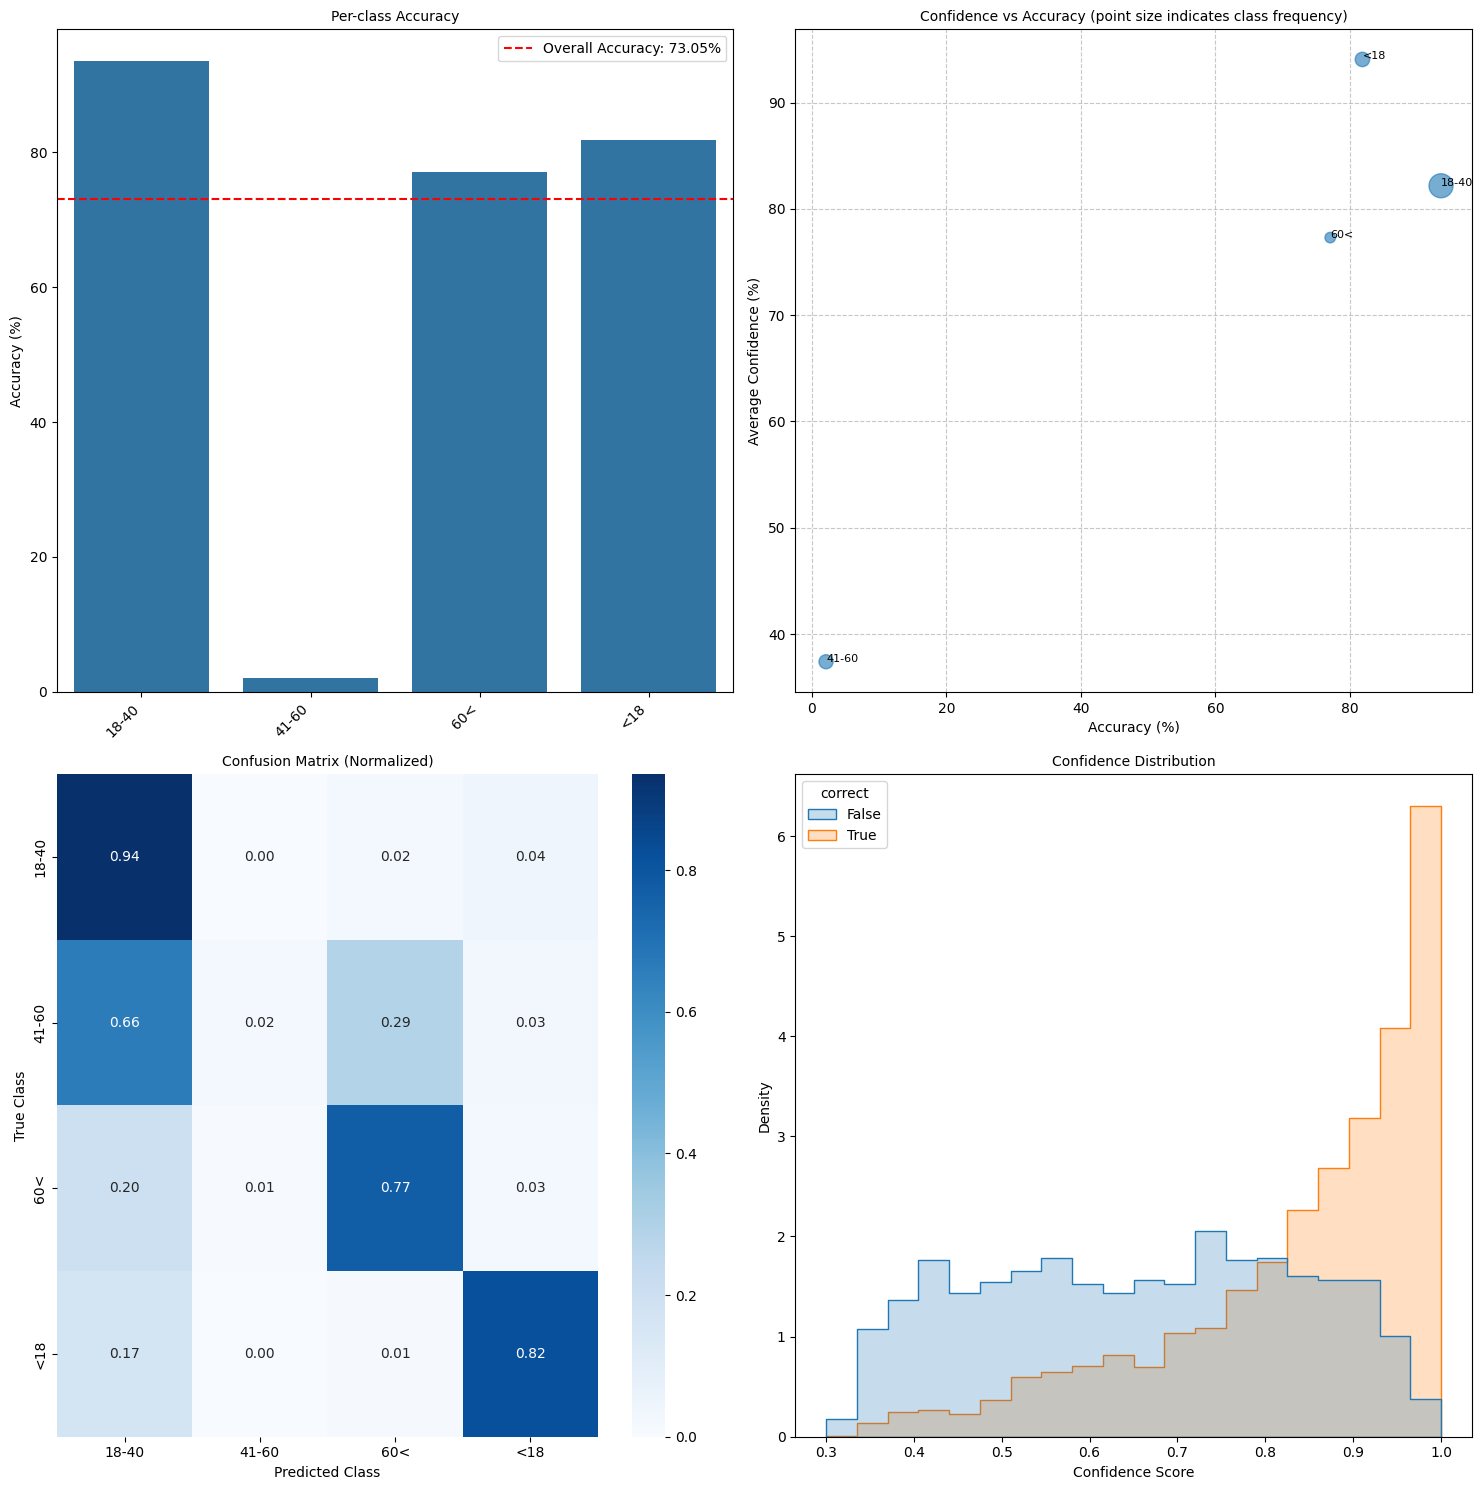

Fold 2 - Best Validation Loss: 0.5548, Best Validation Accuracy: 76.54%


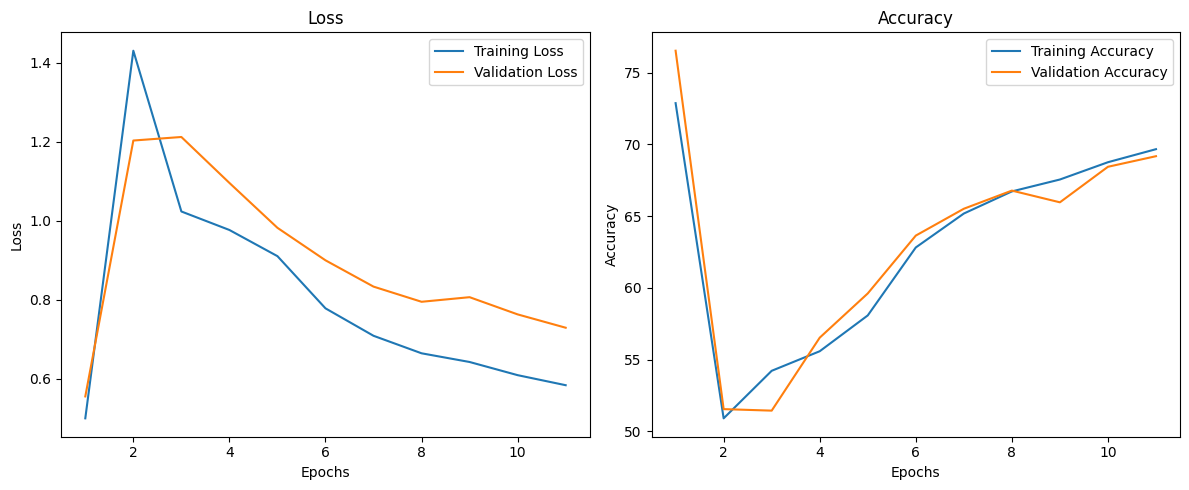

Testing: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]


Overall Test Accuracy: 76.85%

Per-class Performance:
class_name  accuracy  avg_confidence  support
     18-40 95.681727        0.868797     2501
     41-60 14.965197        0.459957      862
       60< 69.166667        0.699104      480
       <18 87.875417        0.943319      899
Evaluating process completed in 00:08.191


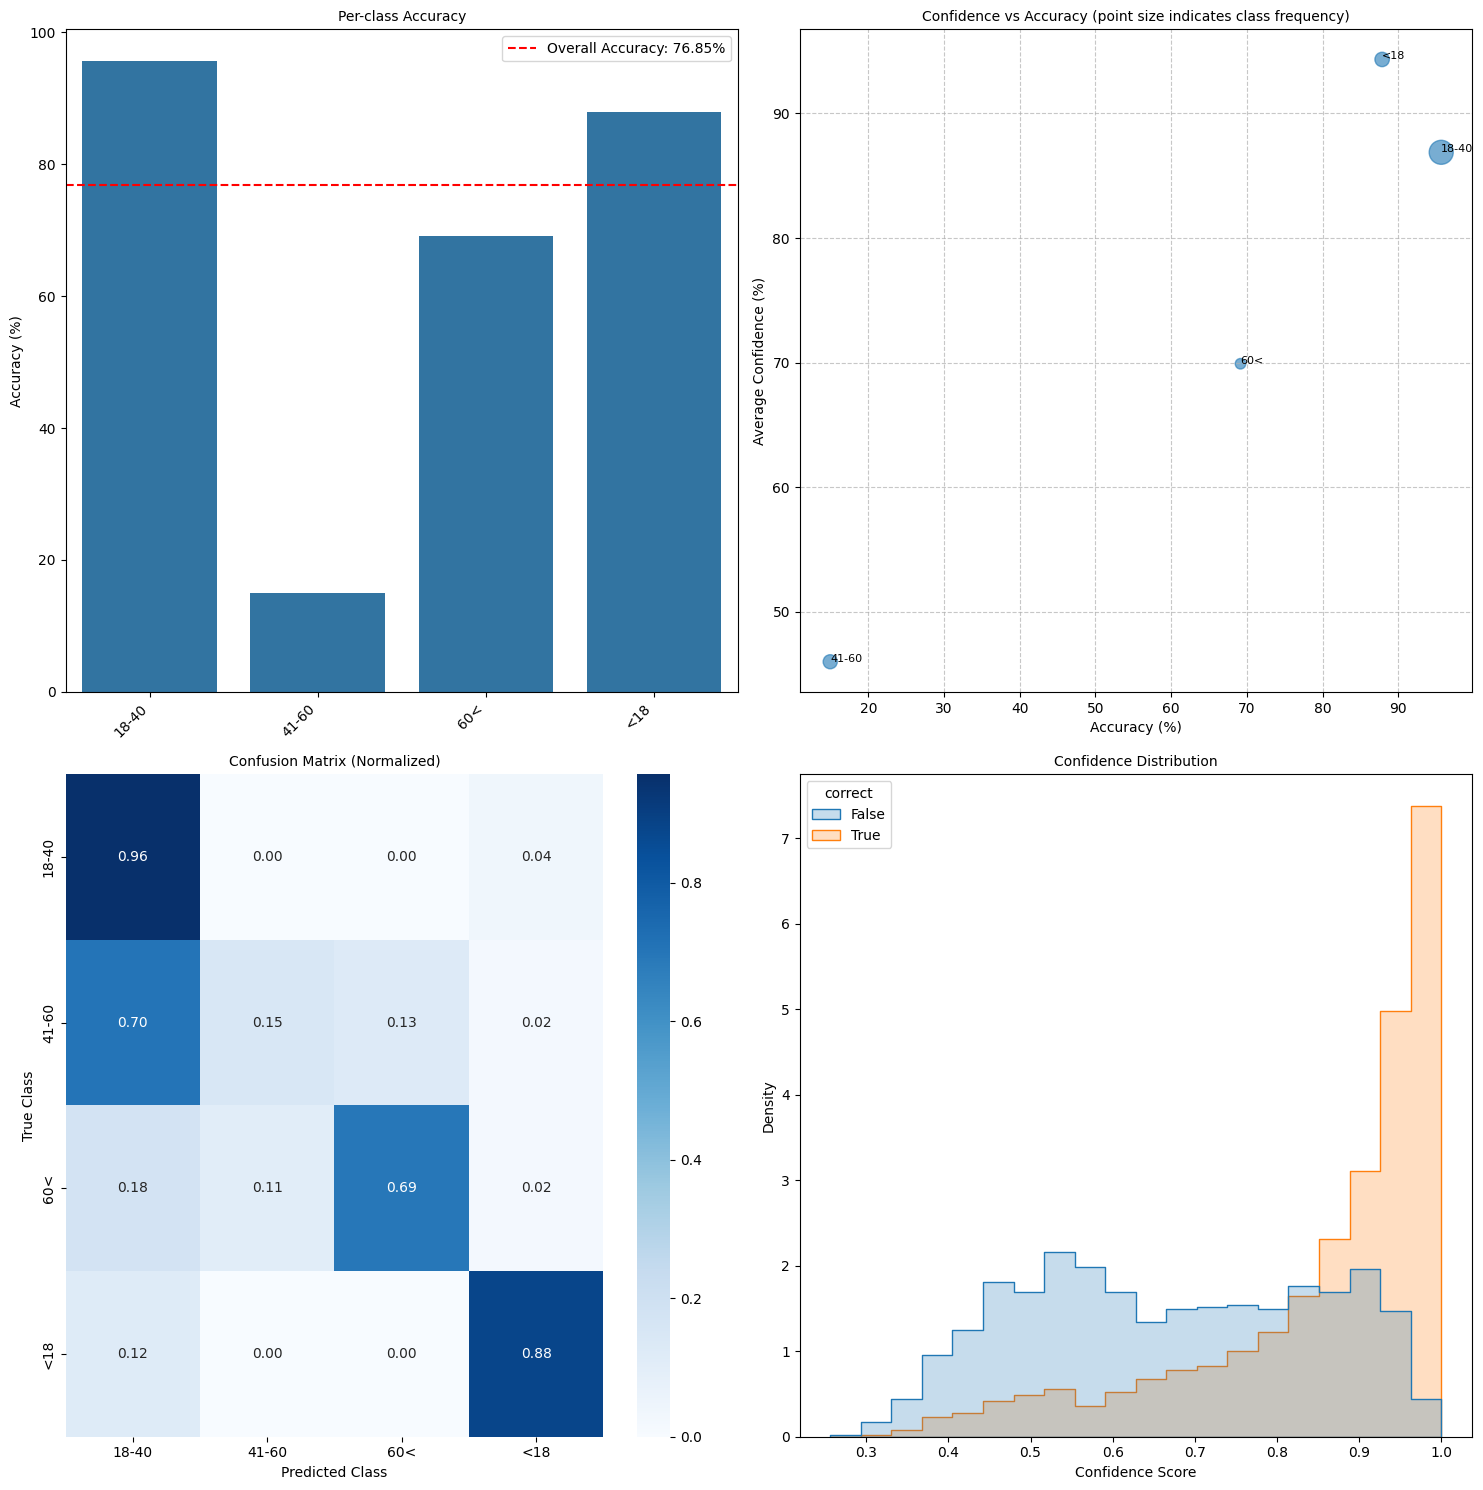

Fold 3 - Best Validation Loss: 0.6282, Best Validation Accuracy: 74.82%


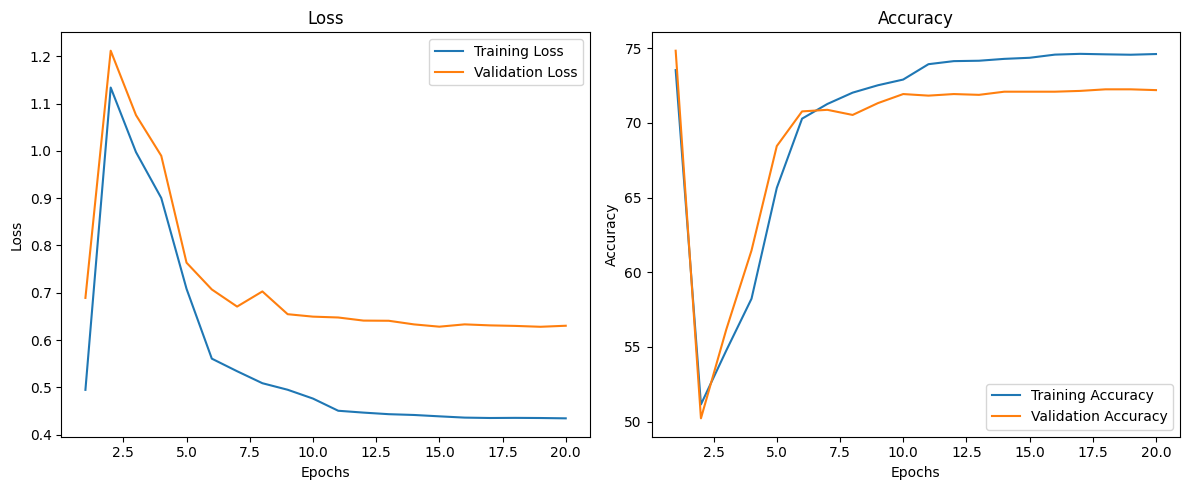

Testing: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


Overall Test Accuracy: 72.61%

Per-class Performance:
class_name  accuracy  avg_confidence  support
     18-40 92.323071        0.840531     2501
     41-60  3.132251        0.401914      862
       60< 73.958333        0.791323      480
       <18 83.648498        0.941262      899
Evaluating process completed in 00:08.066


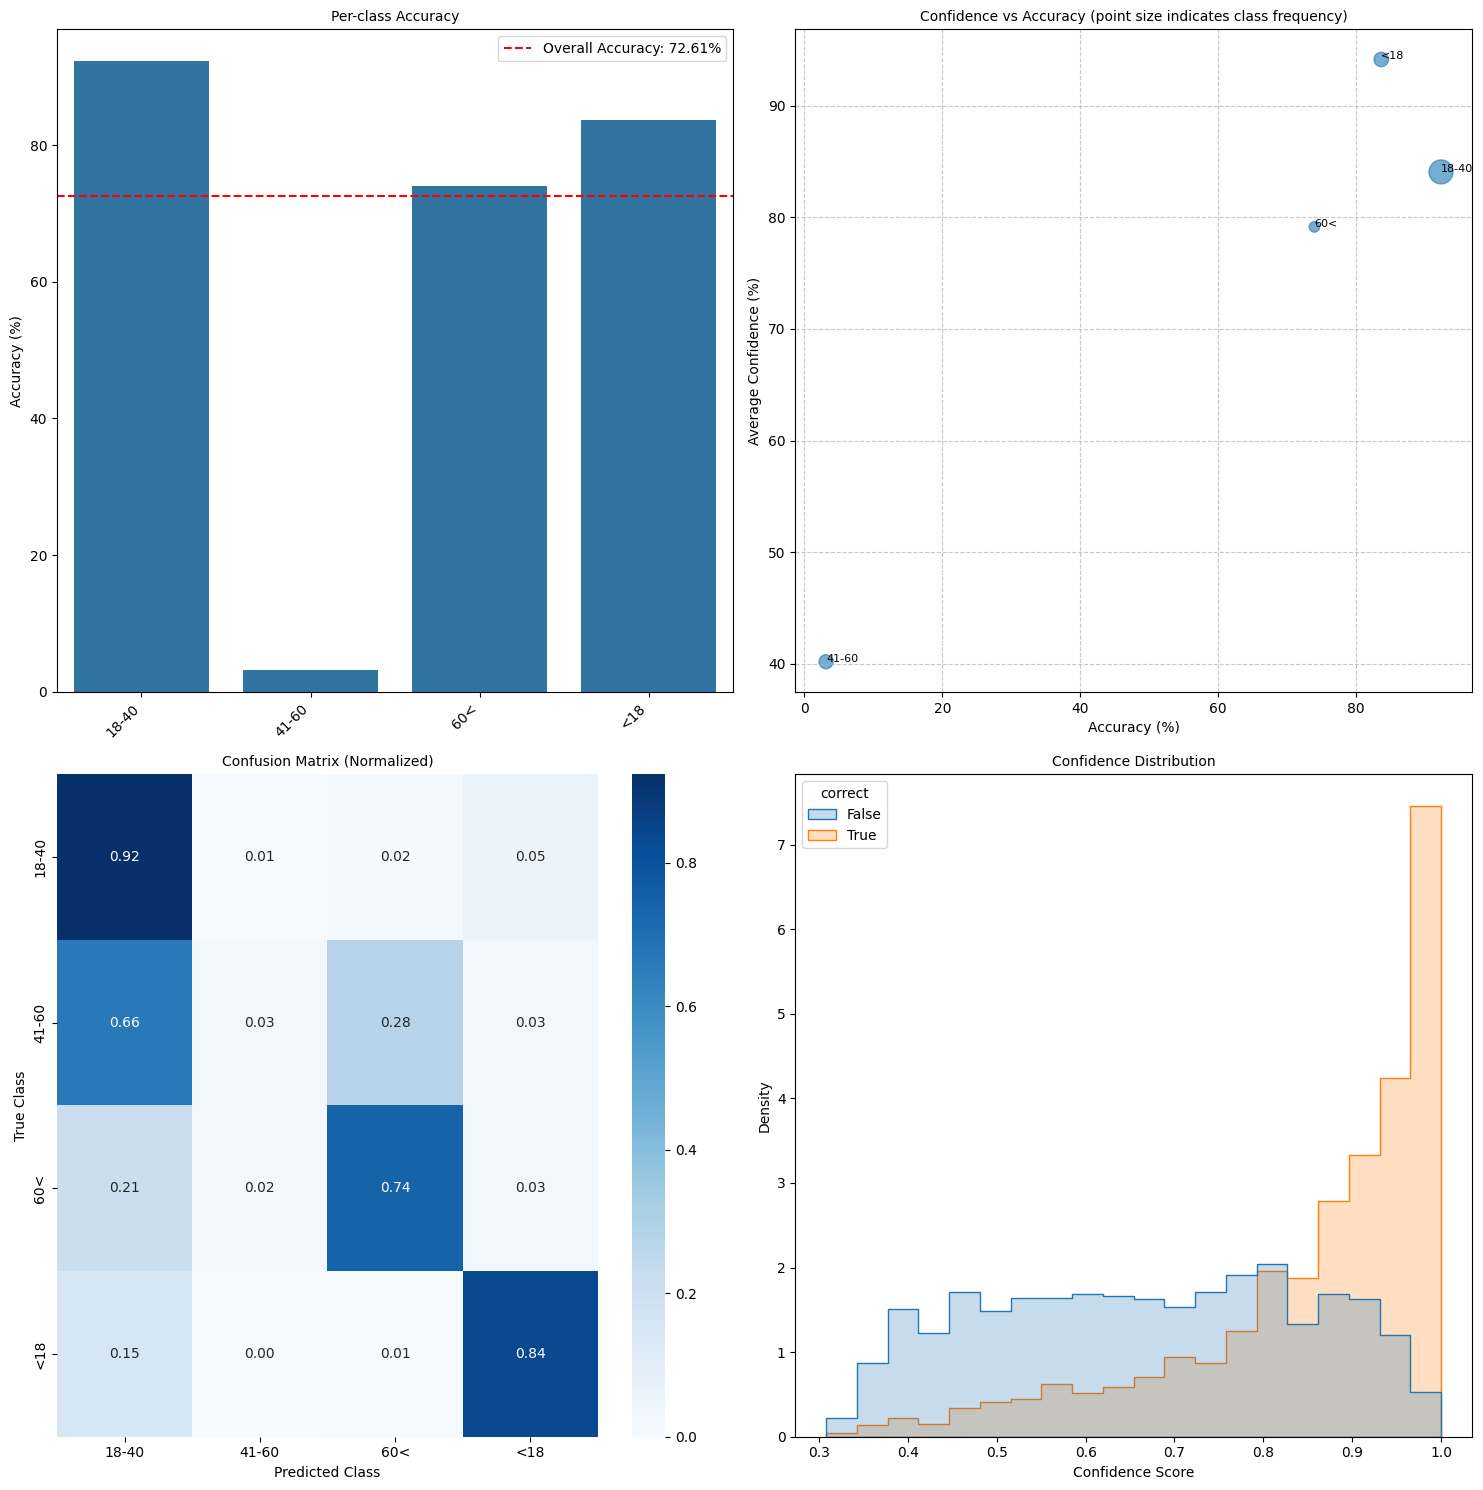

Fold 4 - Best Validation Loss: 0.5977, Best Validation Accuracy: 75.59%


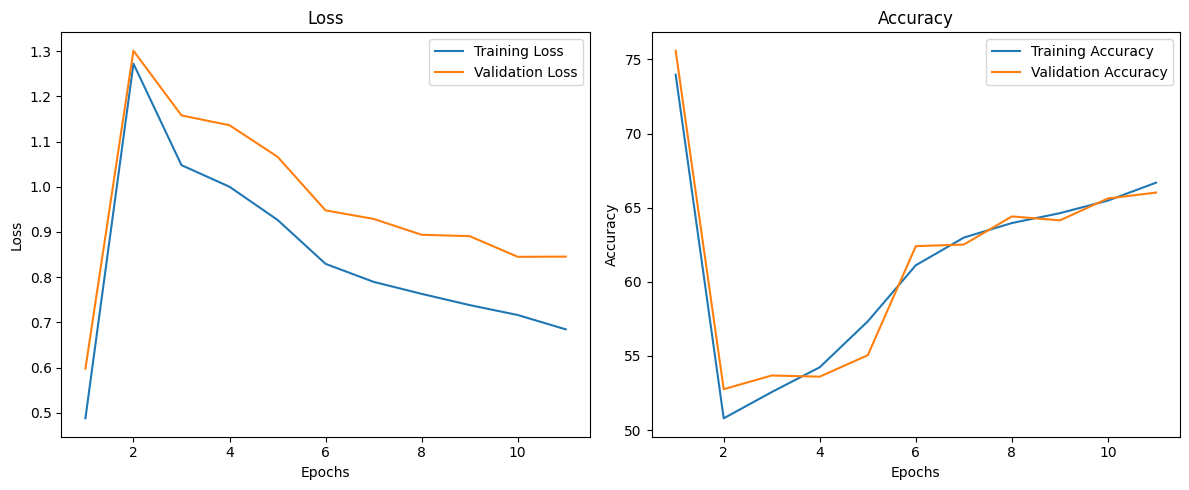

Testing: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


Overall Test Accuracy: 75.85%

Per-class Performance:
class_name  accuracy  avg_confidence  support
     18-40 97.560976        0.881576     2501
     41-60 11.368910        0.480667      862
       60< 55.625000        0.747070      480
       <18 88.097887        0.937194      899
Evaluating process completed in 00:08.160


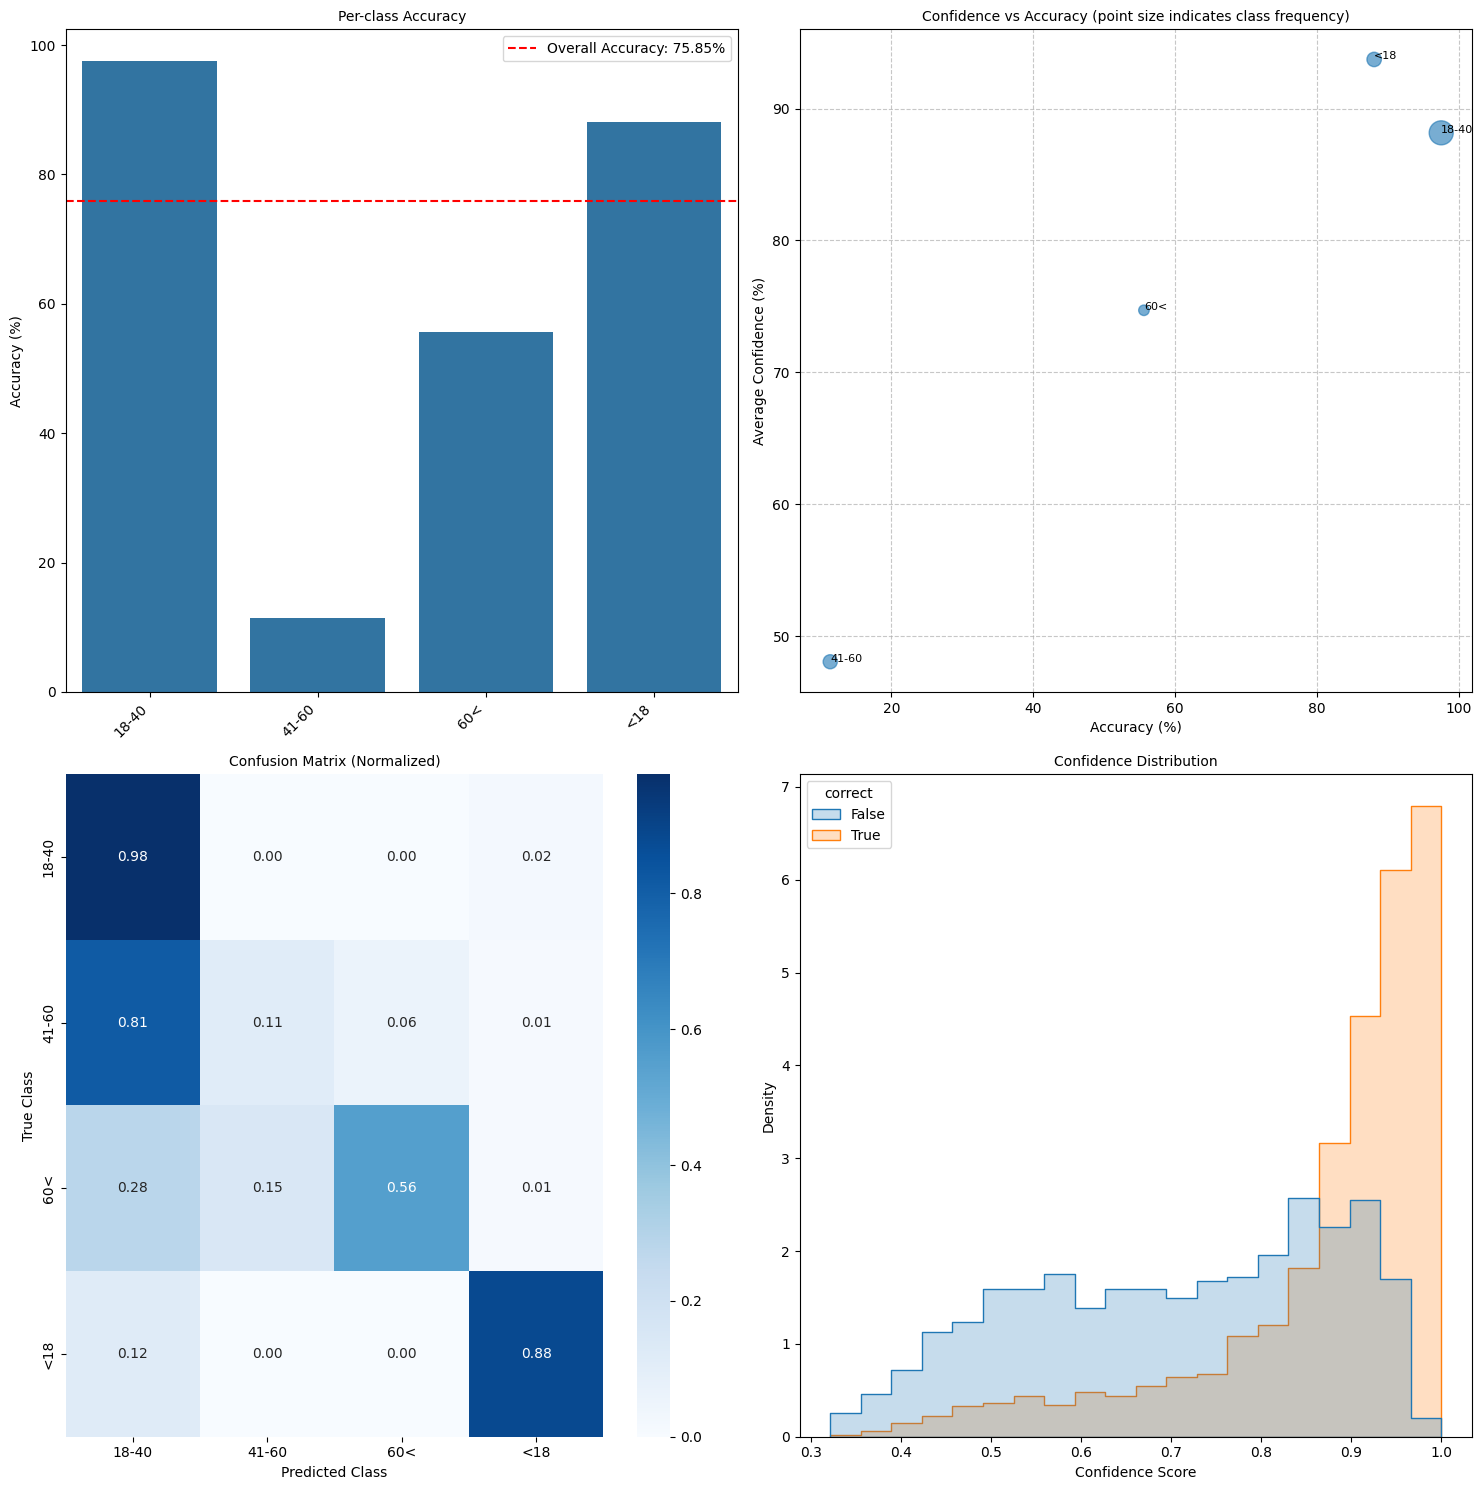

Fold 5 - Best Validation Loss: 0.5969, Best Validation Accuracy: 73.56%


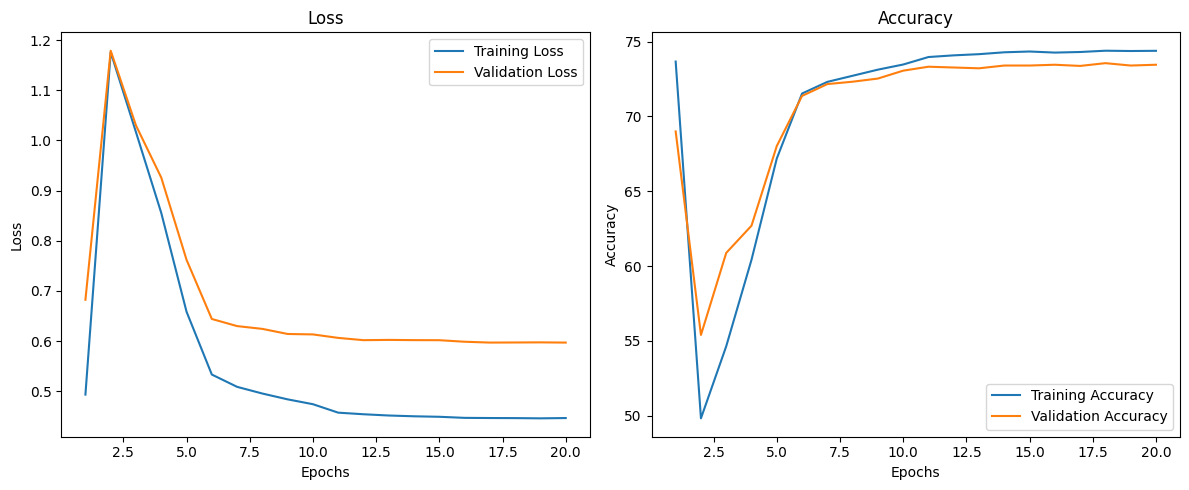

Testing: 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]


Overall Test Accuracy: 72.65%

Per-class Performance:
class_name  accuracy  avg_confidence  support
     18-40 92.323071        0.836835     2501
     41-60  2.436195        0.397585      862
       60< 76.041667        0.785528      480
       <18 83.426029        0.947810      899
Evaluating process completed in 00:07.966


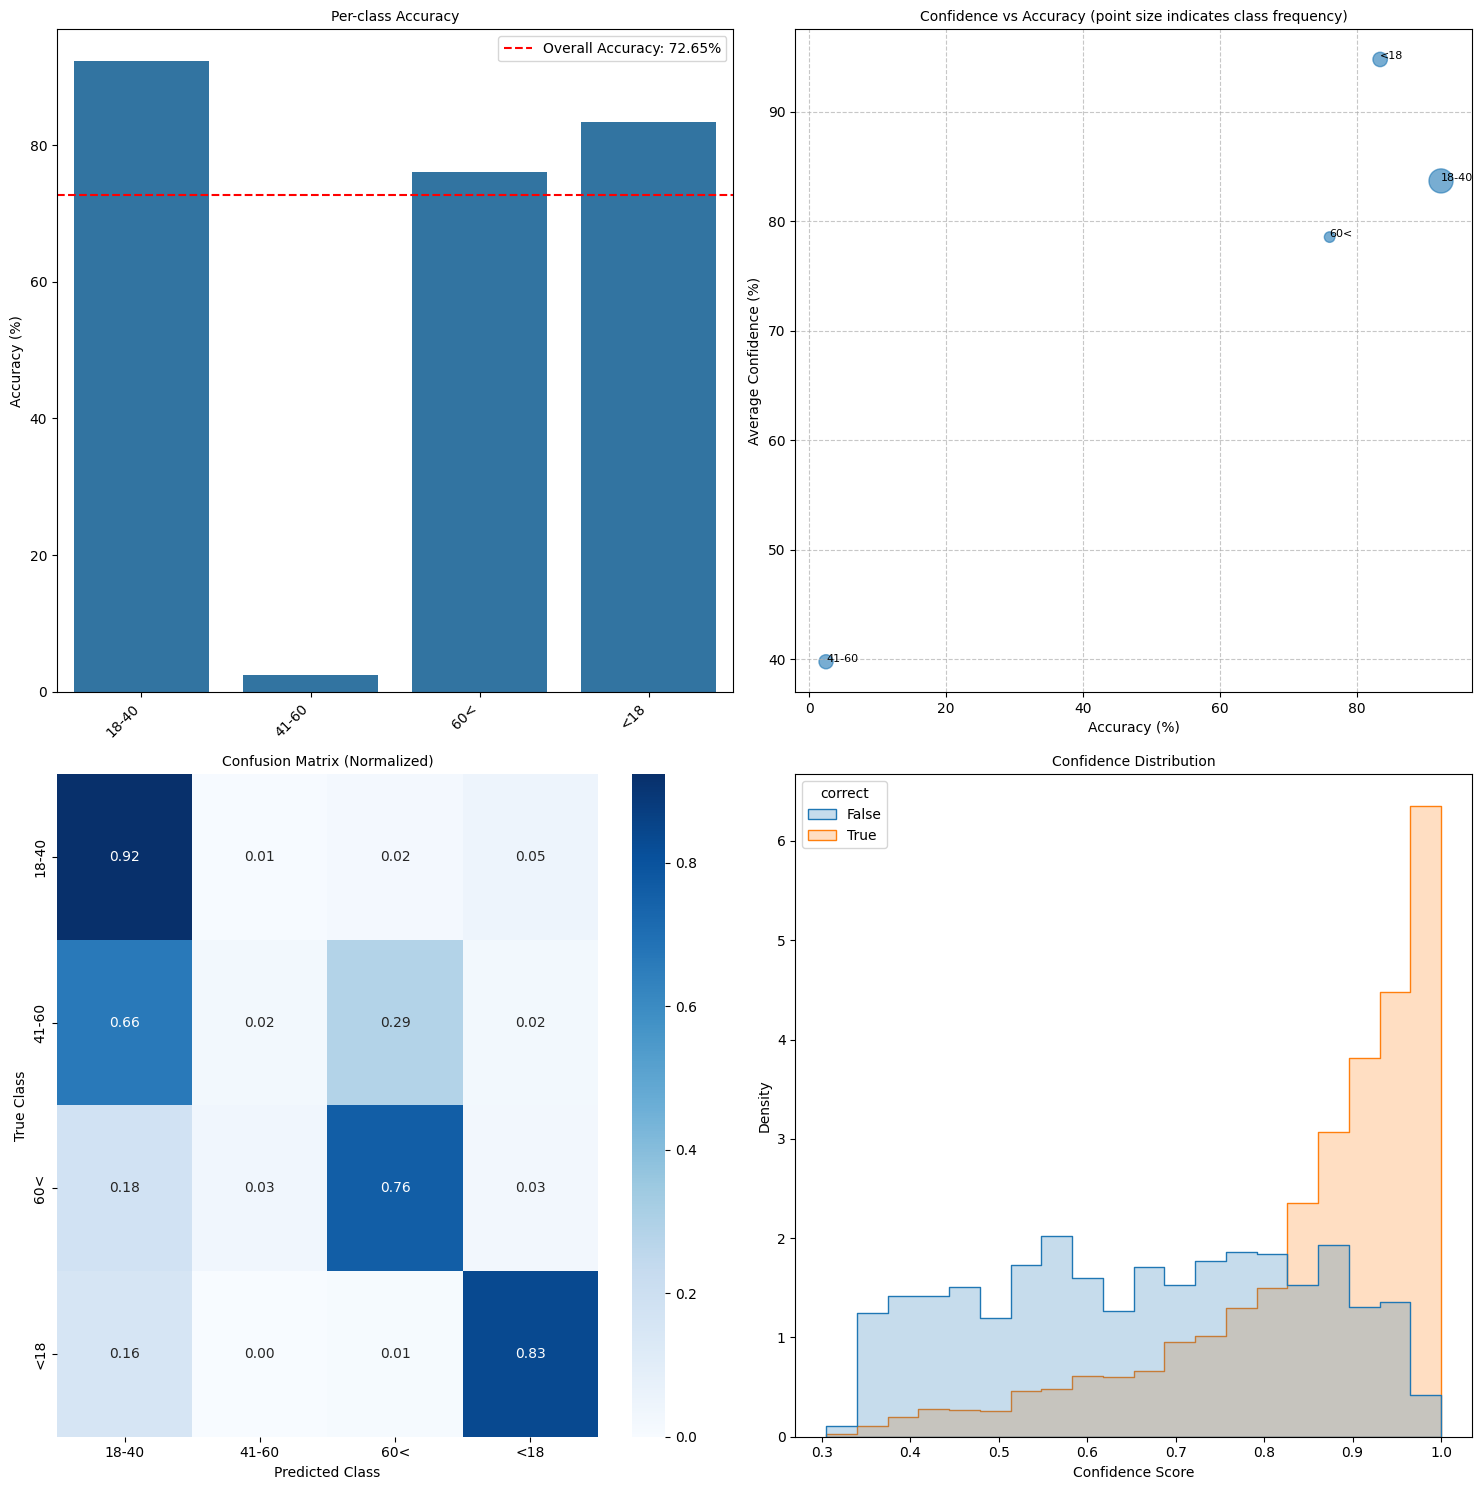

In [15]:
print(f"Loading best model from {results_folder}...")

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds_list = []
    all_labels_list = []
    all_probs_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            all_preds_list.extend(preds.cpu().numpy())
            all_labels_list.extend(labels.cpu().numpy())
            all_probs_list.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    return running_loss / total_samples, (correct_predictions.double() / total_samples).item(), all_labels_list, all_preds_list, all_probs_list

def test_model(
        model: nn.Module,
        test_loader: torch.utils.data.DataLoader,
        device: torch.device,
        class_names: list[str],
        print_per_class_summary: bool = True,
        collect_embeddings: bool = False,
):
    # Set model to evaluation mode
    model.eval()

    # Move model to device
    model.to(device)

    # Per-image results storage
    per_image_data = {
        'image_idx': [],
        'true_label': [],
        'true_class': [],
        'predicted_label': [],
        'predicted_class': [],
        'confidence': [],
        'correct': [],
        'probs': []
    }

    if collect_embeddings and hasattr(model, 'return_features'):
        all_embeddings = []
        embed_labels_idx = []
    else:
        collect_embeddings = False

    # Disable gradient calculation for inference
    with torch.no_grad():
        img_idx = 0  # Global image index counter. Only really useful for if the test_loader does not shuffle
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            batch_size = inputs.shape[0]

            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            if collect_embeddings:
                all_embeddings.append(outputs[1].cpu().numpy())
                outputs = outputs[0]
                embed_labels_idx.append(labels.cpu().numpy())
            else:
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence_values, predicted = torch.max(probabilities, dim=1)

            # Process each sample in the batch
            for i in range(batch_size):
                # Extract individual values
                true_label = labels[i].item()
                pred_label = predicted[i].item()
                conf = confidence_values[i].item()
                probs = probabilities[i].cpu().numpy()

                # Store in per-image data
                per_image_data['image_idx'].append(img_idx + i)
                per_image_data['true_label'].append(true_label)
                per_image_data['true_class'].append(class_names[true_label])
                per_image_data['predicted_label'].append(pred_label)
                per_image_data['predicted_class'].append(class_names[pred_label])
                per_image_data['confidence'].append(conf)
                per_image_data['correct'].append(pred_label == true_label)
                per_image_data['probs'].append(probs)

            img_idx += batch_size

    # Create per-image DataFrame
    per_image_df = pd.DataFrame(per_image_data)

    # Calculate overall accuracy
    overall_accuracy = 100 * per_image_df['correct'].mean()

    # Create aggregated metrics
    aggregate_data = []
    for i, class_name in enumerate(class_names):
        # Filter for this class
        class_samples = per_image_df[per_image_df['true_label'] == i]

        class_accuracy = 100 * class_samples['correct'].mean()
        # Average confidence for correct predictions only
        correct_samples = class_samples[class_samples['correct']]
        avg_confidence = correct_samples['confidence'].mean() if len(correct_samples) > 0 else 0

        aggregate_data.append({
            'class_name': class_name,
            'accuracy': class_accuracy,
            'avg_confidence': avg_confidence,
            'support': len(class_samples)
        })

    # Create aggregate DataFrame
    aggregate_df = pd.DataFrame(aggregate_data)

    # Print summary
    print(f'Overall Test Accuracy: {overall_accuracy:.2f}%')
    if print_per_class_summary:
        print("\nPer-class Performance:")
        print(aggregate_df.to_string(index=False))

    if collect_embeddings:
        # Concatenate all batches (List[np.ndarray] to np.ndarray)
        embeddings = {
            'all_embeddings': np.concatenate(all_embeddings, axis=0),
            'all_labels': np.concatenate(embed_labels_idx, axis=0)
        }

        return aggregate_df, per_image_df, overall_accuracy, embeddings
    else:
        return aggregate_df, per_image_df, overall_accuracy

def visualize_test_results(aggregate_df: pd.DataFrame,
                           per_image_df: pd.DataFrame,
                           overall_accuracy: float,
                           output_dir: Optional[str] = None,
                           class_subset: Optional[Union[List[str], Tuple[str]]] = None,
                           max_classes_display: int = 20,
                           ):
    """
    Visualize test results with support for class subsetting.
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Filter data based on class_subset if provided, otherwise limit by max_classes_display
        if class_subset:
            # Ensure all classes in subset exist in the data
            valid_classes = set(aggregate_df['class_name'])
            invalid_classes = [c for c in class_subset if c not in valid_classes]
            if invalid_classes:
                print(f"Warning: Some specified classes not found in data: {invalid_classes}")

            # Filter to include only specified classes
            filtered_aggregate_df = aggregate_df[aggregate_df['class_name'].isin(class_subset)]
            filtered_per_image_df = per_image_df[
                (per_image_df['true_class'].isin(class_subset)) |
                (per_image_df['predicted_class'].isin(class_subset))
                ]

            # If no classes match, warn and use original data
            if len(filtered_aggregate_df) == 0:
                print("Warning: No classes from subset found in data. Using all available classes.")
                filtered_aggregate_df = aggregate_df
                filtered_per_image_df = per_image_df
        else:
            # If too many classes, select top classes by support count
            if len(aggregate_df) > max_classes_display:
                print(f"More than {max_classes_display} classes found. "
                    f"Displaying top {max_classes_display} by support count.")
                filtered_aggregate_df = aggregate_df.sort_values('support', ascending=False).head(max_classes_display)
                top_classes = filtered_aggregate_df['class_name'].tolist()
                filtered_per_image_df = per_image_df[
                    (per_image_df['true_class'].isin(top_classes)) |
                    (per_image_df['predicted_class'].isin(top_classes))
                    ]
            else:
                filtered_aggregate_df = aggregate_df
                filtered_per_image_df = per_image_df

        # Get number of classes for plot sizing
        num_classes = len(filtered_aggregate_df)

        # Set up figure resolution based on the number of classes
        if num_classes > 50:
            plt.figure(figsize=(40, 40))
            fontsize = 20
            rotation = 90
        elif num_classes > 10:
            plt.figure(figsize=(25, 25))
            fontsize = 12
            rotation = 90
        else:
            plt.figure(figsize=(15, 15))
            fontsize = 10
            rotation = 45

        # 1. Plot accuracy by class
        plt.subplot(2, 2, 1)
        bar_plot = sns.barplot(x='class_name', y='accuracy', data=filtered_aggregate_df)
        plt.axhline(y=overall_accuracy, color='r', linestyle='--',
                    label=f'Overall Accuracy: {overall_accuracy:.2f}%')
        plt.title('Per-class Accuracy', fontsize=fontsize)
        plt.xticks(rotation=rotation, ha='right')
        plt.ylabel('Accuracy (%)', fontsize=fontsize)
        plt.xlabel('', fontsize=fontsize)  # Hide x-label as it's obvious
        plt.legend()

        # Adjust x-tick label size if many classes
        if num_classes > 10:
            bar_plot.set_xticklabels(bar_plot.get_xticklabels(), fontsize=max(6, fontsize - 4))

        # 2. Plot confidence vs accuracy by class
        plt.subplot(2, 2, 2)
        plt.scatter(
            filtered_aggregate_df['accuracy'],
            filtered_aggregate_df['avg_confidence'] * 100,
            s=filtered_aggregate_df['support'] / filtered_aggregate_df['support'].max() * 300,
            alpha=0.6
        )

        # Add class labels to the scatter plot - adjust text size if many classes
        text_size = max(6, fontsize - 4) if num_classes > 15 else fontsize - 2
        for i, txt in enumerate(filtered_aggregate_df['class_name']):
            plt.annotate(txt,
                        (filtered_aggregate_df['accuracy'].iloc[i],
                        filtered_aggregate_df['avg_confidence'].iloc[i] * 100),
                        fontsize=text_size)

        plt.title('Confidence vs Accuracy (point size indicates class frequency)', fontsize=fontsize)
        plt.xlabel('Accuracy (%)', fontsize=fontsize)
        plt.ylabel('Average Confidence (%)', fontsize=fontsize)
        plt.grid(True, linestyle='--', alpha=0.7)

        # 3. Plot confusion matrix - only if we have true labels (not for test set with unknown labels)
        plt.subplot(2, 2, 3)

        # Check if we have actual true labels (not dummy -1 values)
        if filtered_per_image_df['true_class'].nunique() > 1 and -1 not in filtered_per_image_df['true_class'].unique():
            # Create confusion matrix
            cm = pd.crosstab(
                filtered_per_image_df['true_class'],
                filtered_per_image_df['predicted_class'],
                normalize='index'
            )

            # Adjust annot and fontsize based on matrix size
            annot = True if len(cm) <= 30 else False
            annot_kws = {'fontsize': max(6, fontsize - 6)} if len(cm) > 10 else {}

            sns.heatmap(cm, annot=annot, fmt='.2f', cmap='Blues', annot_kws=annot_kws)
            plt.title('Confusion Matrix (Normalized)', fontsize=fontsize)
            plt.ylabel('True Class', fontsize=fontsize)
            plt.xlabel('Predicted Class', fontsize=fontsize)
        else:
            plt.text(0.5, 0.5, "True labels unavailable for confusion matrix",
                    ha='center', va='center', fontsize=fontsize)
            plt.axis('off')

        # 4. Plot confidence distribution by correctness
        plt.subplot(2, 2, 4)

        # Check if we have actual correctness data
        if 'correct' in filtered_per_image_df.columns and -1 not in filtered_per_image_df['true_class'].unique():
            sns.histplot(data=filtered_per_image_df, x='confidence', hue='correct',
                        bins=20, element='step', common_norm=False, stat='density')
            plt.title('Confidence Distribution', fontsize=fontsize)
            plt.xlabel('Confidence Score', fontsize=fontsize)
            plt.ylabel('Density', fontsize=fontsize)
        else:
            # For test set with unknown labels
            sns.histplot(data=filtered_per_image_df, x='confidence', bins=20)
            plt.title('Prediction Confidence Distribution (true labels unknown)', fontsize=fontsize)
            plt.xlabel('Confidence Score', fontsize=fontsize)
            plt.ylabel('Count', fontsize=fontsize)

        plt.tight_layout()

        if output_dir is not None:
            os.makedirs(output_dir, exist_ok=True)
            output_file = 'test_results.png'
            if class_subset:
                # Create a filename based on subset
                subset_str = '_'.join(class_subset[:3])  # Use first 3 classes in name
                if len(class_subset) > 3:
                    subset_str += "_etc"
                output_file = f'test_results_{subset_str}.png'

            plt.savefig(os.path.join(output_dir, output_file), dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

    except ImportError:
        print("Matplotlib and/or seaborn not available for visualization.")

# For each fold, load the best model and history
for fold in range(5):
    # fold = 5
    model = create_model(num_classes)
    model.load_state_dict(torch.load(os.path.join(results_folder, f"best_model_fold_{fold + 1}.pth")))
    
    # Load history
    history = np.load(os.path.join(results_folder, f"history_fold_{fold + 1}.npy"), allow_pickle=True).item()

    print(f"Fold {fold + 1} - Best Validation Loss: {min(history['val_loss']):.4f}, Best Validation Accuracy: {max(history['val_accuracy']):.2f}%")
    
    # Loss and Accuracy Plots
    epochs_range_total = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range_total, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range_total, history['val_loss'], label='Validation Loss')
    if num_epochs < len(history['train_loss']): plt.axvline(x=num_epochs, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(); plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range_total, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs_range_total, history['val_accuracy'], label='Validation Accuracy')
    if num_epochs < len(history['train_accuracy']): plt.axvline(x=num_epochs, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(); plt.title('Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
    plt.tight_layout(); plt.show()

    # Evaluate on Test Set
    # evaluate model on validation set
    with timer("Evaluating process"):
        aggregate_df, per_image_df, overall_accuracy = test_model(model=model,
                                                                            test_loader=test_loader,
                                                                            device=device,
                                                                            class_names=classes,
                                                                            print_per_class_summary=True,
                                                                            collect_embeddings=True,)
    
    # Call the visualization function
    visualize_test_results(
        aggregate_df=aggregate_df,
        per_image_df=per_image_df,
        overall_accuracy=overall_accuracy,
        output_dir=None)


    